# Installation of required packages and libraries

In [ ]:
# The versions are important otherwise the package dependencies will likely fail
print('\nINSTALLING REQUIRED PACKAGES...')
!pip install --upgrade pip==21.1.3

!pip install --upgrade setuptools==59.5.0
# CPU version of pytorch has smaller footprint - see installation instructions in
# pytorch documentation - https://pytorch.org/get-started/locally/
#!python -m pip install mitmproxy
#!pip install torch==1.10.1+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install torch==1.10.2 -f https://download.pytorch.org/whl/cpu/torch_stable.html

# AutoGluon(2020): This popular AutoML open-source toolkit developed by AWS helps in getting a strong predictive performance 
# in various machine learning and deep learning models on text, image, and tabular data.
!pip install autogluon

!pip install --upgrade scikit-learn==1.0.0

print('\nREQUIRED PACKAGES INSTALLED')

In [ ]:
# For visualisation of plots
!pip install seaborn

In [ ]:
# For writing/saving structural alert images to excel file
!pip install xlsxwriter

# Automated machine learning model training and evaluation

In [2]:
# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer

#======================================================================================#
# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def get_MACCS_fingerprint(smiles):
    
    
    
    return fingerprint_df


# This function is expecting a input csv with two columns 'SMILES' and 'Binary Activity'
def split_train_test(csv,test_ratio,train_save,test_save,overwrite):
    
    # Read input and shuffle randomly
    input_df = pd.read_csv(csv)
    print(input_df)
    input_df = input_df.sample(frac=1)
    input_np = input_df.to_numpy()
    
    # split df randomly according to specified ratio
    train_df, test_df = train_test_split(input_np, test_size=test_ratio)
    
    train_df = pd.DataFrame(train_df,columns=['SMILES','Binary Activity'])
    test_df = pd.DataFrame(test_df,columns=['SMILES','Binary Activity'])
    
    # Save files
    # Ovewrite existing file present in folder
#     print(isfile(train_save))
#     print(isfile(test_save))
    if overwrite == False and isfile(train_save) == True:
        train_save = train_save[:-4] + str(randrange(100)) + train_save[-4:]
        train_df.to_csv(train_save)        
    else:
        train_df.to_csv(train_save)
    
    if overwrite == False and isfile(test_save) == True:
        test_save = test_save[:-4] + str(randrange(100)) + test_save[-4:]
        test_df.to_csv(test_save)        
    else:
        test_df.to_csv(test_save)
    
    
    return train_save,test_save

def most_probable_class(column_list):
    col_val = set(column_list)
    most_prob_class_count = 0
    most_prob_class = 0
    for ele in col_val:
        class_count = column_list.count(ele)
        if class_count > most_prob_class_count:
            most_prob_class_count = class_count
            most_prob_class = ele
            
    return most_prob_class


def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):

    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
# The function is expecting a training and test set with SMILES and Binary Activity (2 columns in total)
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    
    # Define metrics for validation here
    # If using a different metric other than accuracy, note that the preset below needs to be changed as well
    # Otherwise, the model will focus on acc
    metric = 'accuracy'
    ag_sensitivity_scorer = make_scorer(name='SE',
                             score_func=sensitivity,
                             optimum=1,
                             greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
    # Best quality improves performance but takes longer to run. Medium_quality is the default setting.
    # For more details see the AutoGluon package documentation
#     preset = 'best_quality'
    preset = 'medium_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=ag_sensitivity_scorer,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return
#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'
root_desc = 'V2.0.1 Unified data max SP medium'
root = 'C:/Users/mwhw3/Desktop/DART project/'
input_path = root + root_desc + '.csv'

total_runs = 5

overall_save = root + 'AutoML models combined results/' + root_desc + ' ' + str(total_runs) +' runs.csv'
#overall_save = root + 'AutoML models combined results/' + root_desc + ' all Unified data external prediction' + \
str(total_runs) +' runs.csv'

for run in range(1,total_runs+1):
    
    print('\n#=========================================================================================#')
    print('#=========================================================================================#')
    print('\n                               NOW PERFORMING RUN {}\n'.format(run))
    print('#=========================================================================================#')
    print('#=========================================================================================#')
    
    desc = root_desc + ' ' + str(run)
    check_path = root + 'AutoML models/' + desc + '/' + 'Data/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
        
    # Save locations for training and test sets                              
    train_save = root + 'AutoML models/' + desc + '/' + 'Data/' + desc + ' CSV train.csv'
    test_save = root + 'AutoML models/' + desc + '/' + 'Data/' + desc + ' CSV test.csv'

    # Save location for model results
    model_name = root + 'AutoML models/' + desc + '/' + 'Models/'
    if os.path.exists(model_name)== False:
        os.makedirs(model_name)
    check_path = root + 'AutoML models/' + desc + '/' + 'Results/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
    model_results = root + 'AutoML models/' + desc + '/' + 'Results/' + desc + ' model results.csv'

    # The AutoGluon package creates a folder if one is not present
    # Otherwise it will save in the specified filepath
    save_path = root + 'AutoML models/' + desc + '/'                            
    #==============================================================================================#                             
    # Main code
    #input_csv = pd.read_csv(input_path)
    training_set,test_set = split_train_test(input_path,0.2,train_save,test_save,True)                              

    # If running AutoGluon model code                         
    AutoGluon(training_set,test_set,save_path,model_results,model_name)
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                             ALL MODELS TRAINED AND EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')

#==============================================================================================#
#==============================================================================================#    
# Combine results for models across all runs    

# Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'
#col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
col_ls = ['model','SE','SP','Acc','MCC']

result_dict = {}
for run in range(1,total_runs+1):
    desc = root_desc + ' ' + str(run)
    model_results = root + 'AutoML models/' + desc + '/' + 'Results/' + desc + ' model results.csv'
    results_df = pd.read_csv(model_results)
    results_df = results_df[col_ls]
    results_name = str(results_df) + str(run)
    result_dict[results_name] = results_df
    
combined_df = pd.concat(result_dict.values())
#print(combined_df)
mean_df = combined_df.groupby(by=['model']).mean()

print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF MEANS\n'                                      )
print('#=========================================================================================#\n')

mean_df['SE'] = 100 * mean_df['SE']
mean_df['SP'] = 100 * mean_df['SP']
mean_df['Acc'] = 100 * mean_df['Acc']

mean_df = mean_df.round({'SE': 1,'SP': 1,'Acc': 1,'MCC': 3}).astype(str)
print(mean_df)

std_df = combined_df.groupby(by=['model']).agg(np.std)
print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF STD\n'                                        )
print('#=========================================================================================#\n')

std_df['SE'] = 100 * std_df['SE']
std_df['SP'] = 100 * std_df['SP']
std_df['Acc'] = 100 * std_df['Acc']

std_df = std_df.round({'SE': 1,'SP': 1,'Acc': 1,'MCC': 3}).astype(str)
print(std_df)

overall_df = mean_df

overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']
overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

print('\n#=========================================================================================#')
print('\n                                 OVERALL DATAFRAME\n'                                        )
print('#=========================================================================================#\n')

overall_df.to_csv(overall_save)
print(overall_df)


print('\nFINISHED')


#=========================================================================================#
#=========================================================================================#

                               NOW PERFORMING RUN 1

#=========================================================================================#
#=========================================================================================#
                                                 SMILES  Binary Activity
0                                S=P(N1CC1)(N1CC1)N1CC1                1
1              CC1(OC(=O)N(C1=O)C1=CC(Cl)=CC(Cl)=C1)C=C                1
2         SCCC(=O)OCC(COC(=O)CCS)(COC(=O)CCS)COC(=O)CCS                0
3                                  SC1=NC2=C(S1)C=CC=C2                0
4                                      SC(=S)NCCNC(S)=S                1
...                                                 ...              ...
3250  [H][C@]12OC[C@H](O[N+]([O-])=O)[C@@]1([H])OC[C...           

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Unified data max SP medium 1/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    2604
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    27833.83 MB
	Train Data (Original)  Memory Usage: 21.33 MB (0.1% of ava

      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     1     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2599     0     0     0     0     0     0     0     0     0     0  ...     0   
2600     0     1     0     0     0     0     0     0     0     0  ...     0   
2601     0     1     0     0     0     0     0     0     0     0  ...     0   
2602     0     0     0     0     0     0     0     0     0     0  ...     0   
2603     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2046 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 2): ['236', '1678']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2046 | ['0', '1', '2', '3', '4', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('int', ['bool']) : 2046 | ['0', '1', '2', '3', '4', ...]
	8.5s = Fit runtime
	2046 features in original data used to generate 2046 features in processed data.
	Train Data (Processed) Memory Usage: 5.33 MB (0.0% of availabl


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP  FP  FN   TN        SE        SP  \
0    ExtraTreesEntr_BAG_L1    0.778443  260  90  74  227  0.778443  0.716088   
1  RandomForestGini_BAG_L1    0.775449  259  88  75  229  0.775449  0.722397   
2    ExtraTreesGini_BAG_L1    0.766467  256  84  78  233  0.766467  0.735016   
3  RandomForestEntr_BAG_L1    0.766467  256  84  78  233  0.766467  0.735016   
4      WeightedEnsemble_L2    0.766467  256  84  78  233  0.766467  0.735016   
5    ExtraTreesGini_BAG_L2    0.751497  251  83  83  234  0.751497  0.738170   
6      WeightedEnsemble_L3    0.751497  251  83  83  234  0.751497  0.738170   
7    ExtraTreesEntr_BAG_L2    0.748503  250  69  84  248  0.748503  0.782334   
8  RandomForestEntr_BAG_L2    0.736527  246  67  88  250  0.736527  0.788644   
9  RandomForestGini_BAG_L2    0.724551  242  68  92  249  0.724551  0.785489   

        Acc       MCC  score_val  pred_time_test  pred_time_val  fit_time  \
0  0

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Unified data max SP medium 2/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    2604
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    27736.6 MB
	Train Data (Original)  Memory Usage: 21.33 MB (0.1% of avai

      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     1     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2599     0     0     0     0     0     0     0     0     0     0  ...     0   
2600     0     1     0     0     0     0     0     0     0     0  ...     0   
2601     0     0     0     0     0     0     0     0     0     0  ...     0   
2602     0     0     0     0     0     0     0     0     0     0  ...     0   
2603     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2046 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 2): ['236', '1902']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2046 | ['0', '1', '2', '3', '4', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('int', ['bool']) : 2046 | ['0', '1', '2', '3', '4', ...]
	8.3s = Fit runtime
	2046 features in original data used to generate 2046 features in processed data.
	Train Data (Processed) Memory Usage: 5.33 MB (0.0% of availabl


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP   FP  FN   TN        SE        SP  \
0  RandomForestGini_BAG_L1    0.726154  236  103  89  223  0.726154  0.684049   
1    ExtraTreesGini_BAG_L2    0.723077  235   95  90  231  0.723077  0.708589   
2    ExtraTreesEntr_BAG_L2    0.720000  234   93  91  233  0.720000  0.714724   
3    ExtraTreesGini_BAG_L1    0.716923  233   99  92  227  0.716923  0.696319   
4      WeightedEnsemble_L2    0.716923  233   99  92  227  0.716923  0.696319   
5    ExtraTreesEntr_BAG_L1    0.713846  232   95  93  231  0.713846  0.708589   
6  RandomForestEntr_BAG_L1    0.713846  232  100  93  226  0.713846  0.693252   
7      WeightedEnsemble_L3    0.713846  232   94  93  232  0.713846  0.711656   
8  RandomForestGini_BAG_L2    0.710769  231   83  94  243  0.710769  0.745399   
9  RandomForestEntr_BAG_L2    0.704615  229   86  96  240  0.704615  0.736196   

        Acc       MCC  score_val  pred_time_test  pred_time_val   fit_

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Unified data max SP medium 3/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    2604
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    27776.39 MB
	Train Data (Original)  Memory Usage: 21.33 MB (0.1% of ava

      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     1     0  ...     0   
4        0     0     1     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2599     0     1     0     0     0     0     0     0     0     0  ...     0   
2600     0     1     0     0     0     0     0     0     0     0  ...     0   
2601     0     0     0     0     0     0     0     0     0     0  ...     0   
2602     0     1     0     0     0     0     0     0     0     0  ...     0   
2603     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2046 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 2): ['236', '1229']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2046 | ['0', '1', '2', '3', '4', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('int', ['bool']) : 2046 | ['0', '1', '2', '3', '4', ...]
	8.1s = Fit runtime
	2046 features in original data used to generate 2046 features in processed data.
	Train Data (Processed) Memory Usage: 5.33 MB (0.0% of availabl


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP  FP   FN   TN        SE        SP  \
0  RandomForestGini_BAG_L1    0.759036  252  95   80  224  0.759036  0.702194   
1      WeightedEnsemble_L2    0.759036  252  95   80  224  0.759036  0.702194   
2    ExtraTreesEntr_BAG_L1    0.746988  248  84   84  235  0.746988  0.736677   
3    ExtraTreesGini_BAG_L2    0.734940  244  83   88  236  0.734940  0.739812   
4      WeightedEnsemble_L3    0.734940  244  83   88  236  0.734940  0.739812   
5    ExtraTreesGini_BAG_L1    0.728916  242  92   90  227  0.728916  0.711599   
6  RandomForestEntr_BAG_L1    0.725904  241  88   91  231  0.725904  0.724138   
7    ExtraTreesEntr_BAG_L2    0.725904  241  77   91  242  0.725904  0.758621   
8  RandomForestGini_BAG_L2    0.707831  235  78   97  241  0.707831  0.755486   
9  RandomForestEntr_BAG_L2    0.695783  231  73  101  246  0.695783  0.771160   

        Acc       MCC  score_val  pred_time_test  pred_time_val  fit_t

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Unified data max SP medium 4/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    2604
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    27780.46 MB
	Train Data (Original)  Memory Usage: 21.33 MB (0.1% of ava

      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2599     0     0     0     0     0     0     0     0     0     0  ...     0   
2600     0     1     0     0     1     0     0     0     0     0  ...     0   
2601     0     0     0     0     0     0     0     0     0     0  ...     0   
2602     0     0     0     0     0     0     0     0     0     0  ...     0   
2603     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2045 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 3): ['148', '236', '1461']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2045 | ['0', '1', '2', '3', '4', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('int', ['bool']) : 2045 | ['0', '1', '2', '3', '4', ...]
	8.2s = Fit runtime
	2045 features in original data used to generate 2045 features in processed data.
	Train Data (Processed) Memory Usage: 5.33 MB (0.0% of a


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP   FP  FN   TN        SE        SP  \
0  RandomForestEntr_BAG_L1    0.798193  265  108  67  211  0.798193  0.661442   
1  RandomForestGini_BAG_L1    0.795181  264  107  68  212  0.795181  0.664577   
2      WeightedEnsemble_L2    0.795181  264  107  68  212  0.795181  0.664577   
3    ExtraTreesGini_BAG_L1    0.792169  263  102  69  217  0.792169  0.680251   
4    ExtraTreesGini_BAG_L2    0.783133  260   95  72  224  0.783133  0.702194   
5    ExtraTreesEntr_BAG_L1    0.780120  259   98  73  221  0.780120  0.692790   
6  RandomForestEntr_BAG_L2    0.777108  258   94  74  225  0.777108  0.705329   
7  RandomForestGini_BAG_L2    0.777108  258  100  74  219  0.777108  0.686520   
8    ExtraTreesEntr_BAG_L2    0.771084  256   92  76  227  0.771084  0.711599   
9      WeightedEnsemble_L3    0.768072  255   94  77  225  0.768072  0.705329   

        Acc       MCC  score_val  pred_time_test  pred_time_val  fit_t

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Unified data max SP medium 5/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    2604
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    27756.78 MB


      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     1     0     0     0     0     0     0     0     0  ...     0   
4        0     1     0     0     0     0     0     0     0     0  ...     1   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2599     0     1     0     0     0     0     0     0     0     0  ...     0   
2600     0     0     0     0     0     0     0     0     0     0  ...     0   
2601     0     0     0     0     0     0     0     0     0     0  ...     0   
2602     0     0     0     0     0     0     0     0     0     0  ...     0   
2603     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Train Data (Original)  Memory Usage: 21.33 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2047 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 1): ['236']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2047 | ['0', '1', '2', '3', '4', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('int', ['bool']) : 


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP   FP  FN   TN        SE        SP  \
0    ExtraTreesGini_BAG_L1    0.760355  257  101  81  212  0.760355  0.677316   
1      WeightedEnsemble_L2    0.745562  252  100  86  213  0.745562  0.680511   
2    ExtraTreesGini_BAG_L2    0.745562  252   88  86  225  0.745562  0.718850   
3  RandomForestEntr_BAG_L2    0.742604  251   85  87  228  0.742604  0.728435   
4      WeightedEnsemble_L3    0.742604  251   89  87  224  0.742604  0.715655   
5  RandomForestGini_BAG_L1    0.739645  250   95  88  218  0.739645  0.696486   
6  RandomForestEntr_BAG_L1    0.739645  250   89  88  224  0.739645  0.715655   
7  RandomForestGini_BAG_L2    0.727811  246   84  92  229  0.727811  0.731629   
8    ExtraTreesEntr_BAG_L2    0.727811  246   89  92  224  0.727811  0.715655   
9    ExtraTreesEntr_BAG_L1    0.724852  245   92  93  221  0.724852  0.706070   

        Acc       MCC  score_val  pred_time_test  pred_time_val  fit_t

# For visualising feature space with PCA or t-SNE


#=========================================================================================#

                                      RUNNING PCA for                                       

                             V2.0.1 in vivo data                             


#=========================================================================================#


input_df no. of SMILES:
1683
1683
   0     1     2     3     4     5     6     7     8     9     ...  2038  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   2039  2040  2041  2042  2043  2044  2045  2046  2047  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0

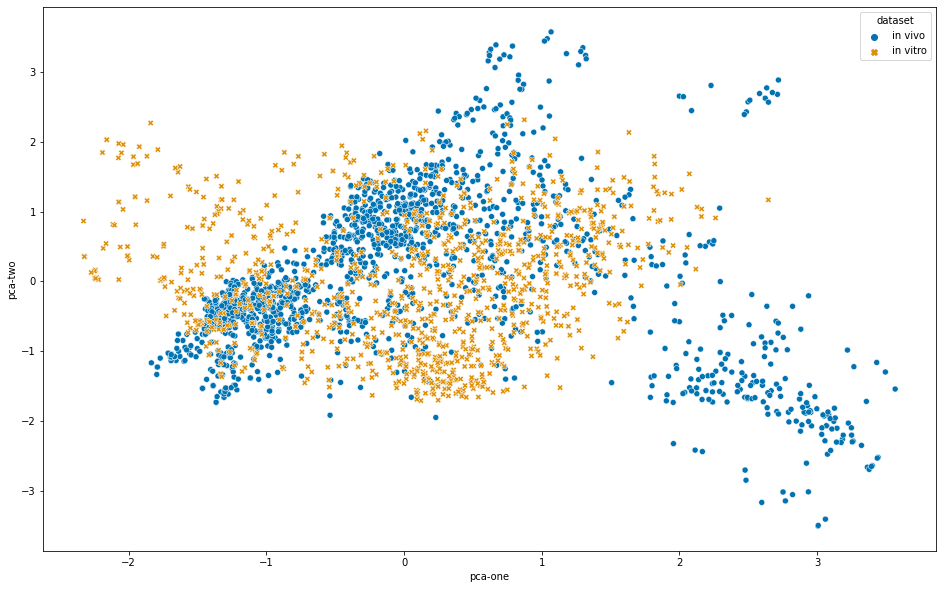

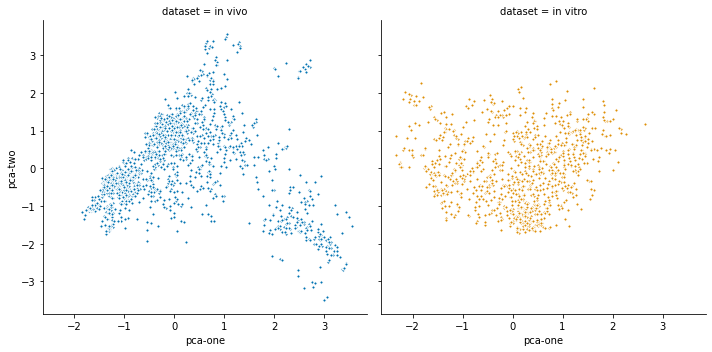


FINISHED


In [1]:
# Code for visualsiing feature space
# t-SNE is used as it known to offer a better visual representation in the 2D plot as compared to PCA

import time

import pandas as pd
import numpy as np

import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

#==============================================================================================#
#==============================================================================================#


# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls


#==============================================================================================#
#==============================================================================================#
# Functions
def input_to_tsne_plot(input_df,filename,perplex,iterations):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING t-SNE for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
    input_df['SMILES'].replace('', np.nan, inplace=True)
    input_df.dropna(subset=['SMILES'], inplace=True)
    input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    print(to_concat)
    
    input_df_smi = input_df['SMILES'].tolist()
    print('\ninput_df no. of SMILES:')
    print(len(input_df_smi))

    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
    plot_data = plot_data.drop(error_idx_ls)
    to_concat = to_concat.drop(error_idx_ls)
    to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    tsne = TSNE(n_components=2, perplexity=perplex,n_iter=iterations,verbose=1)
    tsne_results = tsne.fit_transform(plot_data)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results,to_concat

# # PLotting the t-SNE results
# # This gives the x-axis
# plot_data['tsne-2d-one'] = tsne_results[:,0]
# # This gives the y-axis
# plot_data['tsne-2d-two'] = tsne_results[:,1]

def input_to_pca_plot(input_df,filename):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING PCA for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
    input_df['SMILES'].replace('', np.nan, inplace=True)
    input_df.dropna(subset=['SMILES'], inplace=True)
    input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)
    to_concat = input_df
    input_df_smi = input_df['SMILES'].tolist()
    print('\ninput_df no. of SMILES:')
    print(len(input_df_smi))

    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
    plot_data = plot_data.drop(error_idx_ls)
    to_concat = to_concat.drop(error_idx_ls)
    to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    pca = PCA(n_components = 2)
    pca_results = pca.fit_transform(plot_data)
    print('\nPercentage variance explained: {}'.format(pca.explained_variance_))
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return pca_results,to_concat

def tsne_main(root_desc,perplex,iterations):
    tsne_dict={}
    for filename in root_desc:
        index = root_desc.index(filename)

        if filename == 'external test set 1 no outliers':
            input_path = root + 'Outliers/' + filename + '.csv'

        else:
            input_path = root + filename + '.csv'

        input_df = pd.read_csv(input_path, sep=',')

        tsne_results,to_concat = input_to_tsne_plot(input_df,filename,perplex,iterations)

        tsne_df = pd.DataFrame(tsne_results, columns = ['tsne-2d-one','tsne-2d-two'])
        print(tsne_df.head())

        # Assign label by testing type for plotting later
        if filename == 'V2.0.1 in vivo data':
            new_col = 'in vivo'
        if filename == 'V2.0.1 in vitro data':
            new_col = 'in vitro'              
        
        # Assign label by toxicity endpoint for plotting later
        if filename == 'V2.0.1 Developmental non-toxicants':
            new_col = 'Developmental non-toxicants'
        if filename == 'V2.0.1 Developmental toxicants':
            new_col = 'Developmental toxicants'
        if filename == 'V2.0.1 Reproductive non-toxicants':
            new_col = 'Reproductive non-toxicants'
        if filename == 'V2.0.1 Reproductive toxicants':
            new_col = 'Reproductive toxicants'
              
        
        # Assign label by source for plotting later
        if filename == 'V2.0.1 Stemina data':
            new_col = 'Stemina'

        if filename == 'V2.0.1 Unified data no Stemina data':
            new_col = 'Unified data no Stemina' 

        if filename == 'V2.0.1 VEGA data':
            new_col = 'VEGA'

        if filename == 'V2.0.1 DEREK data':
            new_col = 'DEREK'
            
        if filename == 'V2.0.1 All other data':
            new_col = 'All other data'
            
        if filename == 'V2.0.1 Challa data':
            new_col = 'Challa et al.'

        if filename == 'V2.0.1 Prenatal dev tox':
            new_col = 'Prenatal dev tox'

        if filename == 'V2.0.1 ML data':
            new_col = 'Reproductive tox Feng et al.'

        if filename == 'V2.0.1 external test set':
            new_col = 'External test set'

        if filename == 'external test set no outliers':
            new_col = 'External test set (no outliers)'



        tsne_df = tsne_df.assign(dataset = new_col)    

        tsne_dict[new_col] = tsne_df
    
    return tsne_dict,to_concat

def pca_main(root_desc):
    pca_dict={}
    for filename in root_desc:
        index = root_desc.index(filename)

        if filename == 'external test set no outliers':
            input_path = root + 'Outliers/' + filename + '.csv'

        else:
            input_path = root + filename + '.csv'

        input_df = pd.read_csv(input_path, sep=',')

        pca_results,to_concat = input_to_pca_plot(input_df,filename)

        pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
        print(pca_df.head())

        
        # Assign label by testing type for plotting later
        if filename == 'V2.0.1 in vivo data':
            new_col = 'in vivo'
        if filename == 'V2.0.1 in vitro data':
            new_col = 'in vitro'       
        
        # Assign label by toxicity endpoint for plotting later
        if filename == 'V2.0.1 Developmental non-toxicants':
            new_col = 'Developmental non-toxicants'
        if filename == 'V2.0.1 Developmental toxicants':
            new_col = 'Developmental toxicants'
        if filename == 'V2.0.1 Reproductive non-toxicants':
            new_col = 'Reproductive non-toxicants'
        if filename == 'V2.0.1 Reproductive toxicants':
            new_col = 'Reproductive toxicants'
              
        
        # Assign label by source for plotting later
        if filename == 'V2.0.1 Stemina data':
            new_col = 'Stemina'

        if filename == 'V2.0.1 Unified data no Stemina data':
            new_col = 'Unified data no Stemina' 

        if filename == 'V2.0.1 VEGA data':
            new_col = 'VEGA'

        if filename == 'V2.0.1 DEREK data':
            new_col = 'DEREK'
            
        if filename == 'V2.0.1 All other data':
            new_col = 'All other data'
            
        if filename == 'V2.0.1 Challa data':
            new_col = 'Challa et al.'

        if filename == 'V2.0.1 Prenatal dev tox':
            new_col = 'Prenatal dev tox'

        if filename == 'V2.0.1 ML data':
            new_col = 'Reproductive tox Feng et al.'

        if filename == 'V2.0.1 external test set':
            new_col = 'External test set'

        if filename == 'external test set no outliers':
            new_col = 'External test set (no outliers)'



        pca_df = pca_df.assign(dataset = new_col)    

        pca_dict[new_col] = pca_df
    
    return pca_dict,to_concat


# Input test_points as a dataframe with ['tsne-2d-one'] and ['tsne-2d-two'] as columns
def outlier_detection(query_point,test_points,threshold,points_in_circle):
    
    # Test if there are a certain number of test points within the circle of radius = threshold
    # for a given query point
    # Each point will have a x-value and a y-value   
    
    count = 0
    
    for n in range(0,len(test_points)):
        
        x = test_points.iloc[n]['tsne-2d-one']
        y = test_points.iloc[n]['tsne-2d-two']
        
        x_center = query_point['tsne-2d-one']
        y_center = query_point['tsne-2d-two']
        
        check = ((x - x_center)**2) + ((y - y_center)**2)
        
        if check <= (threshold**2):
            count = count + 1
    
    # function will return true if there are <= the specified no. of points in circle within the radius/threshold
    if count <= points_in_circle:
        return True
    
    else:
        return False

def calc_tsne_outliers(value):
    print('CALCULATING OUTLIERS...')
    query_df = tsne_dict['External test set 1']
    test_df = tsne_dict['Unified data no Stemina']

    outlier_ls = []
    outlier_ls.clear()

    # The threshold specified is the radius
    # TYhe values should be a reasonable distance on the t-SNE plot
    threshold = 25
    points_in_circle = 1

    for query in range(0,len(query_df)):

        if query % 10 == 0:
            print('\nNOW FINDING OUTLIERS FOR INDEX {}'.format(query))

        query_point = query_df.iloc[query] 

        if outlier_detection(query_point,test_df,threshold,points_in_circle) == True:
            outlier_ls.append(query)


    # Get outliers in external test set as df for easy access if necessary
    index = root_desc.index(filename)
    input_path = root + root_desc[1] + '.csv'
    input_df = pd.read_csv(input_path, sep=',')

    outlier_df = input_df.iloc[outlier_ls]
    print('\n')
    print('{} OUTLIERS WERE FOUND ON THIS RUN'.format(outlier_df))

    print('\n')
    print(outlier_df.head())
    
    outlier_df.to_csv(outlier_save)

    # save external test set without outliers
    ext_no_outlier_df = input_df.drop(outlier_ls)
    print(ext_no_outlier_df)
    ext_no_outlier_df.to_csv(ext_no_outlier)        
    
#==============================================================================================#
#==============================================================================================#
# Main code
# Filepaths of csv containing two columsn 'SMILES' and 'Binary Activity' to be input in
# root_desc as a list. This is for plotting t-SNE results of different datasets on the same plot

root = 'C:/Users/mwhw3/Desktop/DART project/'

# root_desc = ['V2.0.1 Stemina data']
# save_desc = 'Stemina data'

# root_desc = ['V2.0.1 Stemina data','V2.0.1 VEGA data','V2.0.1 DEREK data','V2.0.1 Challa data',
#              'V2.0.1 Prenatal dev tox', 'V2.0.1 ML data','V2.0.1 All other data']
# save_desc = 'Data by source'

# root_desc = ['V2.0.1 Developmental non-toxicants','V2.0.1 Developmental toxicants',
#               'V2.0.1 Reproductive non-toxicants','V2.0.1 Reproductive toxicants']
# save_desc = 'Data by toxicity endpoint'

root_desc = ['V2.0.1 in vivo data','V2.0.1 in vitro data']
save_desc = 'Data by testing type'


# Save location for resulting sns plot
plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne.tiff'
plot_save_pca = root + 'Feature plots/'+ save_desc + '_pca.tiff'
plot_save_pca_facet = root + 'Feature plots/'+ save_desc + '_pca_facet.tiff'
#plot_save = root + 'SNS plots/'+ 'Compare Unified data with Stemina' + '.tiff'
#plot_save = root + 'SNS plots/'+ 'Stemina data only' + '.tiff'
#plot_save = root + 'SNS plots/'+ 'Predicting on external test set 1' + '.tiff'

# Change tsne parameters
# Note perplexity is the guess of the number of nearest neighbours per data point

# perplex_ls = [10]
perplex_ls = [10,20,40,60,80]
# iterations = 5000
iterations = 1000
#==================================================================================#  
# # Plot data from specified feature visualisation method on the same axis

# For plotting tsne
# for perplex in perplex_ls:
#     print('\nRUNNING tsne with perplexity:',perplex)
#     tsne_dict,to_concat = tsne_main(root_desc,perplex,iterations)
#     tsne_concatenated = pd.concat(tsne_dict.values(), sort=False, ignore_index=False)
#     tsne_concatenated.columns= ['tsne-2d-one','tsne-2d-two','dataset']
#     plt.figure(figsize=(16,10))
#     sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=tsne_concatenated,
#                     hue='dataset', palette="colorblind", legend="full", style='dataset')

#     plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne_perplex' + str(perplex) + '.tiff'
#     plt.savefig(plot_save_tsne)
#     plt.show()

# For plotting PCA
pca_dict,to_concat = pca_main(root_desc)
pca_concatenated = pd.concat(pca_dict.values(), sort=False, ignore_index=False)  
pca_concatenated.columns= ['pca-one','pca-two','dataset']
plt.figure(figsize=(16,10))
sns.scatterplot(x="pca-one", y="pca-two", data=pca_concatenated,
                hue='dataset', palette="colorblind", legend="full", style='dataset')

# Get tick labels for facet plot
# Remove first and last tick label which are the plot boundaries 
xticks = list(plt.xticks()[0])
xticks = [int(x) for x in xticks]
xticks = xticks[1:-1]

yticks = list(plt.yticks()[0])
yticks = [int(y) for y in yticks]
yticks = yticks[1:-1]
print(xticks)
print(yticks)

#plt.savefig(plot_save_pca)
plt.show()

# Plot Facet grid for PCA plot to better visualise the global structure of the feature space
# This also enables the overlapping compounds to be visaulised better
plots_per_row = 2             # This controls how many plots appear in the Facet Grid plot per row
facet = sns.FacetGrid(pca_concatenated, col="dataset", col_wrap=plots_per_row, palette="colorblind", 
                      hue="dataset", height = 5)
facet = (facet.map(plt.scatter, "pca-one", "pca-two", s=10, edgecolor="w"))

facet.set(xticks=xticks, yticks=yticks)
plt.savefig(plot_save_pca_facet)
plt.show()

    
print('\nFINISHED')

# For loading trained models and predicting on external test set

In [185]:
# Code for using trained models to predict on an external test set or external data

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def get_MACCS_fingerprint(smiles):
    
    
    
    return fingerprint_df


# This function is expecting a input csv with two columns 'SMILES' and 'Binary Activity'
def split_train_test(csv,test_ratio,train_save,test_save,overwrite):
    
    # Read input and shuffle randomly
    input_df = pd.read_csv(csv)
    print(input_df)
    input_df = input_df.sample(frac=1)
    input_np = input_df.to_numpy()
    
    # split df randomly according to specified ratio
    train_df, test_df = train_test_split(input_np, test_size=test_ratio)
    
    train_df = pd.DataFrame(train_df,columns=['SMILES','Binary Activity'])
    test_df = pd.DataFrame(test_df,columns=['SMILES','Binary Activity'])
    
    # Save files
    # Ovewrite existing file present in folder
#     print(isfile(train_save))
#     print(isfile(test_save))
    if overwrite == False and isfile(train_save) == True:
        train_save = train_save[:-4] + str(randrange(100)) + train_save[-4:]
        train_df.to_csv(train_save)        
    else:
        train_df.to_csv(train_save)
    
    if overwrite == False and isfile(test_save) == True:
        test_save = test_save[:-4] + str(randrange(100)) + test_save[-4:]
        test_df.to_csv(test_save)        
    else:
        test_df.to_csv(test_save)
    
    
    return train_save,test_save

def most_probable_class(column_list):
    col_val = set(column_list)
    most_prob_class_count = 0
    most_prob_class = 0
    for ele in col_val:
        class_count = column_list.count(ele)
        if class_count > most_prob_class_count:
            most_prob_class_count = class_count
            most_prob_class = ele
            
    return most_prob_class


def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    


#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
model_root_desc = 'V2.0.1 Unified data'

# Filepath of test csv containing two columsn 'SMILES' and 'Binary Activity'
root_desc = 'V2.0.1 external test set'

root = 'C:/Users/mwhw3/Desktop/DART project/'
test_path = root + root_desc + '.csv'

# Set up test data
X_test,y_test = set_up_test_data(test_path)
test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
y_test = y_test['Binary Activity'].tolist()

total_runs = 5

overall_save = root + 'AutoML models combined results/' + root_desc + ' ' + model_root_desc + ' external prediction ' + \
str(total_runs) +' runs.csv'
#overall_save = root + 'AutoML models combined results/' + root_desc + ' ' + str(total_runs) +' runs.csv'

for run in range(1,total_runs+1):
    
    print('\n#=========================================================================================#')
    print('#=========================================================================================#')
    print('\n                               NOW PERFORMING RUN {}\n'.format(run))
    print('#=========================================================================================#')
    print('#=========================================================================================#')
    
    desc = root_desc + ' ' + str(run)
    model_desc = model_root_desc + ' ' + str(run)

    # Load location for models
    model_name = root + 'AutoML models/' + model_desc + '/' + 'Models/'
    print(model_name)

    # Save location for models results
    check_path = root + 'AutoML models/' + desc + '/' + 'Results/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
        
    model_results = root + 'AutoML models/' + desc + '/' + 'Results/' + desc + ' model results.csv'
                         
    #==============================================================================================#                             

    # Load predictor   
    predictor = TabularPredictor.load(model_name)
    y_pred = predictor.predict(X_test)
    
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL MODELS EVALUATED WITH TEST SET(S)\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#==============================================================================================#
#==============================================================================================#    
# Combine results for models across all runs    

# Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'



#col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
col_ls = ['model','SE','SP','Acc','MCC']

result_dict = {}
result_dict.clear()
for run in range(1,total_runs+1):
    desc = root_desc + ' ' + str(run)
    model_results = root + 'AutoML models/' + desc + '/' + 'Results/' + desc + ' model results.csv'

    results_df = pd.read_csv(model_results)

    results_df = results_df[col_ls]
    #print(results_df)
    results_name = str(results_df) + str(run)
    result_dict[results_name] = results_df

    
combined_df = pd.concat(result_dict.values(),ignore_index=True)


mean_df = combined_df.groupby(by=['model']).mean()

print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF MEANS\n'                                      )
print('#=========================================================================================#\n')

mean_df['SE'] = 100 * mean_df['SE']
mean_df['SP'] = 100 * mean_df['SP']
mean_df['Acc'] = 100 * mean_df['Acc']

mean_df = mean_df.round({'SE': 1,'SP': 1,'Acc': 1,'MCC': 3}).astype(str)
print(mean_df)

std_df = combined_df.groupby(by=['model']).agg(np.std)
print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF STD\n'                                        )
print('#=========================================================================================#\n')

std_df['SE'] = 100 * std_df['SE']
std_df['SP'] = 100 * std_df['SP']
std_df['Acc'] = 100 * std_df['Acc']

std_df = std_df.round({'SE': 1,'SP': 1,'Acc': 1,'MCC': 3}).astype(str)
print(std_df)

# mean_df = mean_df.applymap(str)
# print(mean_df)
# std_df = std_df.applymap(str)
overall_df = mean_df

overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']
overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

print('\n#=========================================================================================#')
print('\n                                 OVERALL DATAFRAME\n'                                        )
print('#=========================================================================================#\n')

overall_df.to_csv(overall_save)
print(overall_df)

print('\nFINISHED')    


SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
68
68

DATA SET UP FOR MODEL

#=========================================================================================#
#=========================================================================================#

                               NOW PERFORMING RUN 1

#=========================================================================================#
#=========================================================================================#
C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Unified data 1/Models/
                      model  score_test  TP  FP  FN  TN        SE        SP  \
0   RandomForestGini_BAG_L1    0.794118  36   9   5  18  0.878049  0.666667   
1     ExtraTreesEntr_BAG_L1    0.779412  35   9   6  18  0.853659  0.666667   
2   RandomForestEntr_BAG_L1    0.779412  34   8   7  19  0.829268  0.703704   
3     ExtraTreesGini_BAG_L1    0.779412  34   8   7  19  0.829268  0.703704   
4       WeightedEn

# For visualising SMILES structural alerts

                                                 SMILES
0                                S=P(N1CC1)(N1CC1)N1CC1
1              CC1(OC(=O)N(C1=O)C1=CC(Cl)=CC(Cl)=C1)C=C
2         SCCC(=O)OCC(COC(=O)CCS)(COC(=O)CCS)COC(=O)CCS
3                                  SC1=NC2=C(S1)C=CC=C2
4                                      SC(=S)NCCNC(S)=S
...                                                 ...
3250  [H][C@]12OC[C@H](O[N+]([O-])=O)[C@@]1([H])OC[C...
3251  [H][C@@]12C[C@H](OC(C)=O)[C@@]([H])([C@@]1(C)C...
3252  [H][C@@]1(CC[C@@]2([H])[C@]3([H])C(O)CC4CC(O)C...
3253                                       [CH]1C=CC=C1
3254                                          [C-]#[O+]

[3255 rows x 1 columns]
51
O-C1-C(-C-C-C-1)-C


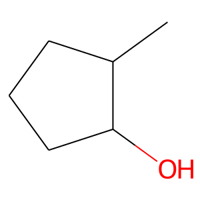

N-C-C-c1:c:c:c:c:c:1


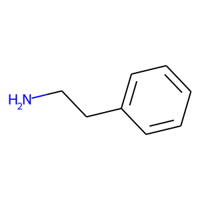

N(-C-C-N)-C-C-O


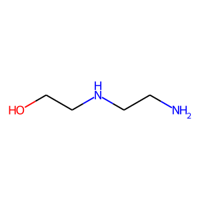

O=C1-C(-C-C-C-1)-C


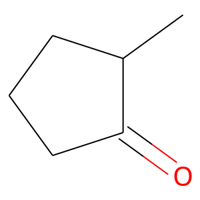

N1(-C-C-C-C-C-1)-C


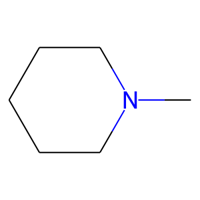

n1:c(:n:c:c:c:1)-N


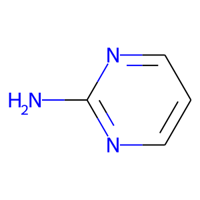

N-C1-O-C(-C-C-1)-C


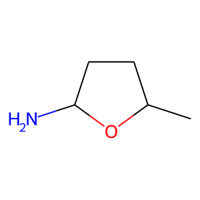

O(-c1:c(:c:c:c:c:1)-C)-C


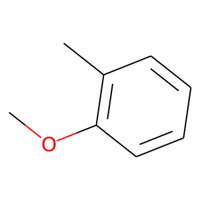

O-C1-C-C(-C-C-C-1)-O


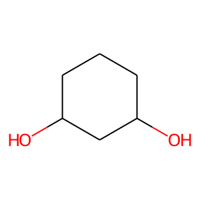

O=C-C1-C2(-C(-C-C-1)-C-C-C-C-2)-C


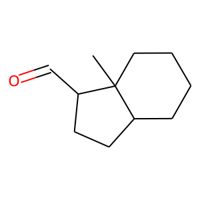

O(-C-c1:c(:c:c:c:c:1)-C)-C


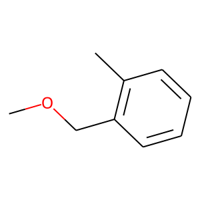

n1(:c:n:c:c:1)-C-C


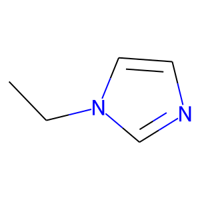

Cl-c1:c:c(:c:c:c:1)-Cl


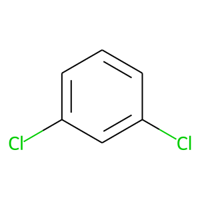

Cl-C-C-N-C-C-Cl


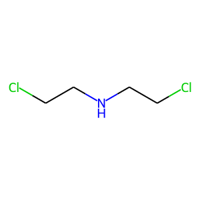

N-C-C-O-c1:c:c:c(:c:c:1)-C


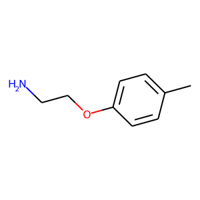

N(-N=O)(-C(-N)=O)-C


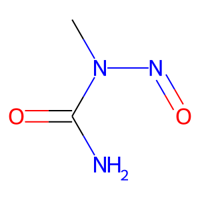

F-c1:c:c:c(:c:c:1)-C


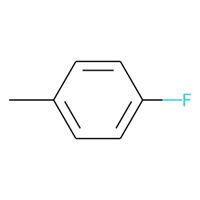

N1-C(-C-N=C(-c2:c-1:c:c:c:c:2)-c1:c:c:c:c:c:1)=O


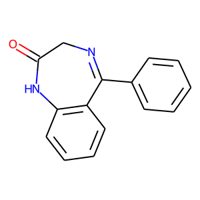

n1:c2:n:c:n:c:c:2:n:c:1


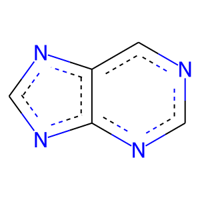

Cl-c1:c:c:c(:c:c:1)-C-c1:c:c:c:c:c:1


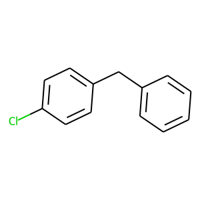

O-C-C=C-C=C-C=C(-C=C-C1-C(-C-C-C-C=1-C)(-C)-C)-C


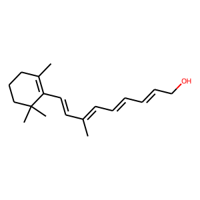

F-C(-F)(-C(-F)(-F)-C(-F)(-F)-C(-F)-C(-F)-C)-C(-F)(-F)-C(-F)-F


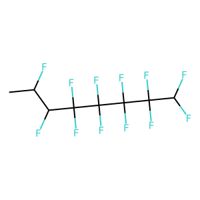

N(-C-C(-N)=O)-C-C


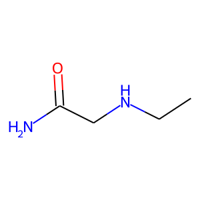

O=C-C-C-C-C-C-C-C(-C)-C


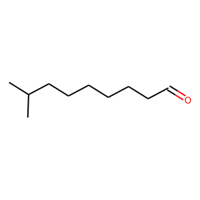

n1:c(:n:c2:c:1:c:c:c:c:2)-N-C(-O-C)=O


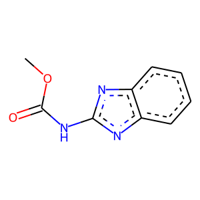

N(-O)(-c1:c(:c:c:c(:c:1)-N(-O)=O)-O)=O


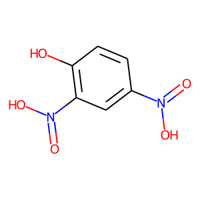

n1:c2:c(:c(:c:1)-C-C):c:c:c:c:2


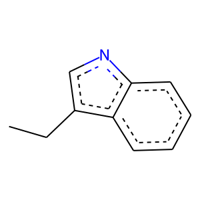

N(-C-C-C-O-c1:c:c:c:c:c:1)-C-C


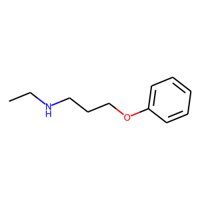

n1:c:c:c(:c:c:1)-C


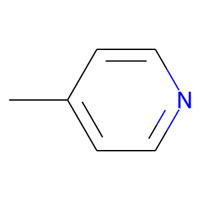

N(-C-C-C(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1)(-C)-C


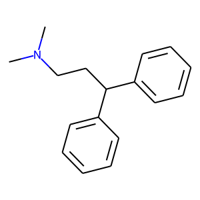

N(-C-C-C-C-C-C-C-C)(-C-C-C-C-C-C-C-C)-C


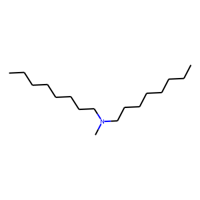

O(-C(-C(-C)=C)=O)-C-C-C-C-C-C-C-C-C-C-C-C


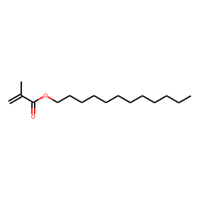

N(-c1:c(:c:c:c:c:1)-N)-C-C


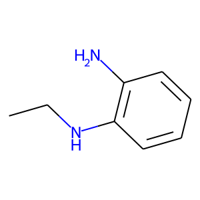

n1:c:n:c:c:c:1-O


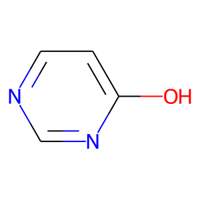

F-C(-F)(-F)-c1:c:c(:c:c:c:1)-N-C(-C(-C)-C)=O


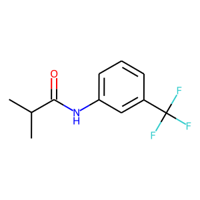

Br-c1:c:c:c(:c:c:1)-O


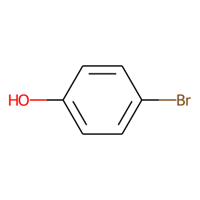

N(-C-c1:o:c:c:c:1)-C


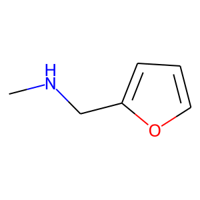

S(-N-C=O)(-C)(=O)=O


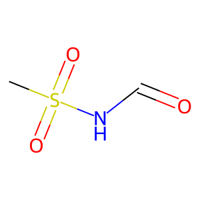

N1(-C-C-N-C-C-1)-C1-c:c-N-c2:c(-N=1):c:c:c:c:2


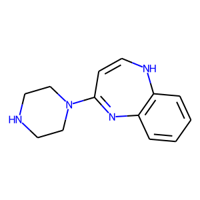

n12-c:c-C(=N-C-c:2:n:n:c:1-C)-c1:c:c:c:c:c:1


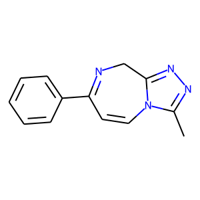

S1-c2:c(-N-c3:c-1:c:c:c:c:3):c:c:c:c:2


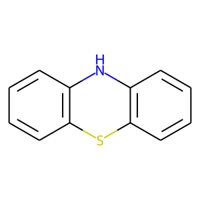

O-C1-C-C2-C(-C-C-1)(-C-C-C-C=2)-C


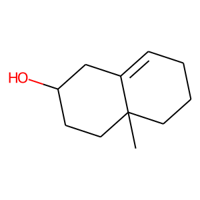

o1:c2:c(:c:c:c:1=O):c:c:c:c:2


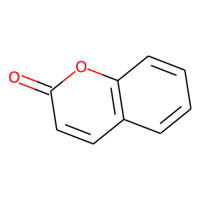

O(-c1:c:c(:c:c:c:1)-C-O-C)-C


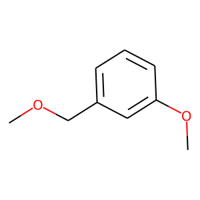

N-C(-c1:c:c:c:c:c:1)-C


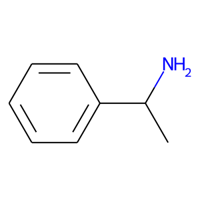

n1:c(:c:c:c:c:1)-N


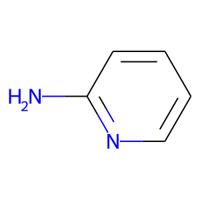

N(-C(-C-N=C)-C)=C


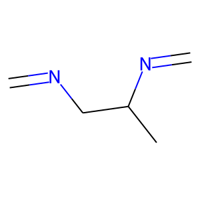

F-C(-F)(-F)-C-O-C


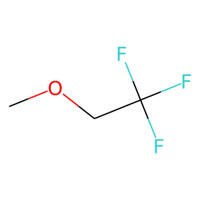

Br-c1:c:c:c:c:c:1


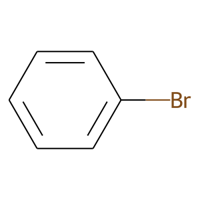

O1-C(-C-C-C-1)-C-O


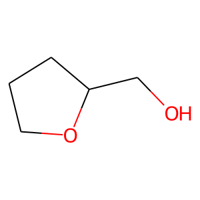

n1:c:n:c:c:c:1-C


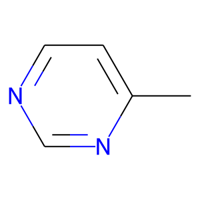


FINISHED


In [12]:
# Code for using trained models to predict on an external test set or external data

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG

import xlsxwriter

from PIL import Image

import csv
#======================================================================================#
root = 'C:/Users/mwhw3/Desktop/DART project/KNIME data/'
root_desc = 'V2.0.1 in vivo data alerts'

input_path = root + root_desc + '.csv'
output_path = root + root_desc + ' with images.xlsx'


# Read input file containing output from Wedlake et al. KNIME workflow
input_df = pd.read_csv(input_path)


# Read input file containing entire DART database of SMILES
DART_path = 'C:/Users/mwhw3/Desktop/DART project/V2.0.1 Unified data.csv'
DART_df = pd.read_csv(DART_path)
DART_SMILES_df = DART_df[['SMILES']]
print(DART_SMILES_df)




# For each alert, go through the DART database and draw the structure of the alert
# using substructure match. This is to avoid RDKIT throwing up errors for unsanitizee fragments or
# other errors involving SMILES fragments. Also, not sanitizing the alerts preserves the information
# of the alerts

check_path = root + root_desc
if os.path.exists(check_path)== False:
    os.makedirs(check_path)

excel_path = check_path + '/' + root_desc + '.xlsx'
workbook = xlsxwriter.Workbook(excel_path)
worksheet = workbook.add_worksheet('Sheet1')
wrap = workbook.add_format({'text_wrap': True})
worksheet.set_column(0, 3, 27.5, wrap)
worksheet.set_row(1, 150, wrap)

# Copy csv values (SMILES,alert hits etc.) to excel file
csv_dict = input_df.to_dict()
#print(csv_dict.items())

col_num = 0
row_num = 1

# for k, v in csv_dict.items():
#     worksheet.write(0, col_num, k)
#     for key, value in v.items():
#         worksheet.write_row(1, row_num, value)
#         row_num += 1
#     col_num += 1
    
n = 2
with open(input_path, 'rt') as f:
    reader = csv.reader(f)
    for r, row in enumerate(reader):
        for c, col in enumerate(row):
            worksheet.write(r, c, col) # write the csv file content into it
    
    f.close()

    
print(len(input_df['Fragment']))    
for s in input_df['Fragment']:
    print(s)
    m = Chem.MolFromSmiles(s,sanitize=False)
    m.UpdatePropertyCache(strict=False)
    img = Draw.MolToImage(m,kekulize=True)
    img_desc = check_path + '/' + 'alert' + str(n-1) + '.png'
    img = img.resize((200,200))
    img.save(img_desc)
    display(img)
    insert_cell = 'D' + str(n)
    worksheet.set_row(n, 150, wrap)
    worksheet.insert_image(insert_cell, img_desc)
    n = n + 1
    
workbook.close()    


print('\nFINISHED')

# Code to run tested models for datasets

This code will load previously saved models and apply them to existing datasets to see which compounds are incorrectly predicted on the test set. The datasets are expected to be different across all runs but there should be some compounds which are consistenly predicted incorrectly.

In [6]:
# Code for using trained models to predict on an external test set or external data

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def get_MACCS_fingerprint(smiles):
    
    
    
    return fingerprint_df


# This function is expecting a input csv with two columns 'SMILES' and 'Binary Activity'
def split_train_test(csv,test_ratio,train_save,test_save,overwrite):
    
    # Read input and shuffle randomly
    input_df = pd.read_csv(csv)
    print(input_df)
    input_df = input_df.sample(frac=1)
    input_np = input_df.to_numpy()
    
    # split df randomly according to specified ratio
    train_df, test_df = train_test_split(input_np, test_size=test_ratio)
    
    train_df = pd.DataFrame(train_df,columns=['SMILES','Binary Activity'])
    test_df = pd.DataFrame(test_df,columns=['SMILES','Binary Activity'])
    
    # Save files
    # Ovewrite existing file present in folder
#     print(isfile(train_save))
#     print(isfile(test_save))
    if overwrite == False and isfile(train_save) == True:
        train_save = train_save[:-4] + str(randrange(100)) + train_save[-4:]
        train_df.to_csv(train_save)        
    else:
        train_df.to_csv(train_save)
    
    if overwrite == False and isfile(test_save) == True:
        test_save = test_save[:-4] + str(randrange(100)) + test_save[-4:]
        test_df.to_csv(test_save)        
    else:
        test_df.to_csv(test_save)
    
    
    return train_save,test_save

def most_probable_class(column_list):
    col_val = set(column_list)
    most_prob_class_count = 0
    most_prob_class = 0
    for ele in col_val:
        class_count = column_list.count(ele)
        if class_count > most_prob_class_count:
            most_prob_class_count = class_count
            most_prob_class = ele
            
    return most_prob_class


def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    
def set_up_interpreting_results(test_path,y_pred,run):
    print('\nSETTING UP RESULTS FOR INTERPRETATION...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    interpret_df = dat_test[['SMILES']]
    interpret_df = interpret_df.join(dat_test['Binary Activity'])
    interpret_df['y_pred'] = y_pred

    # Add columns determining which are misclassified
    # False positives
    FP_ls = []
    FP_ls.clear()
    
    for x in range(0,len(interpret_df)):
        if interpret_df.iloc[x]['Binary Activity'] == 0 and interpret_df.iloc[x]['y_pred'] == 1:
            FP_ls.append("True")
        else:
            FP_ls.append("False")
            
    # False negatives
    FN_ls = []
    FN_ls.clear()
    
    for x in range(0,len(interpret_df)):
        if interpret_df.iloc[x]['Binary Activity'] == 1 and interpret_df.iloc[x]['y_pred'] == 0:
            FN_ls.append("True")
        else:
            FN_ls.append("False")    

    interpret_df['False positive'] = FP_ls
    interpret_df['False negative'] = FN_ls
    
    interpret_df['run_no'] = run
            
    print('\nRESULTS SET UP FOR INTERPRETATION')
    
    return interpret_df

def predict_new_chemicals(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
  
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test
#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
# model_root_desc = 'V2.0.1 Developmental toxicity'
model_root_desc = 'V2.0.1 Reproductive toxicity'

# Filepath of test csv containing two columsn 'SMILES' and 'Binary Activity'
root = 'C:/Users/mwhw3/Desktop/DART project/'


total_runs = 1

overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
str(total_runs) +' runs V2 interpreting predicted results.csv'
#overall_save = root + 'AutoML models combined results/' + root_desc + ' ' + str(total_runs) +' runs.csv'

for run in range(1,total_runs+1):
    
    print('\n#=========================================================================================#')
    print('#=========================================================================================#')
    print('\n                               NOW PERFORMING RUN {}\n'.format(run))
    print('#=========================================================================================#')
    print('#=========================================================================================#')
    
    model_desc = model_root_desc + ' ' + str(run)
    dataset_desc = model_desc +  ' CSV test.csv'

    # Load location for models
    model_name = root + 'AutoML models/' + model_desc + '/' + 'Models/'
    print(model_name)

    # Save location for models results
    check_path = root + 'Urgent chemicals/' + model_desc + '/' + 'Interpreting Predicted Results/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
        
#     model_results = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/' + model_desc + ' interpreting predicted results.csv'
    interpret_df_save = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/' + model_desc + ' V2 interpreting predicted results.csv'
    
    #==============================================================================================#
    # Set up test data
    test_path = root + 'Urgent chemicals/' + 'DART_chemicals.csv'
    
    # If test data has 'Binary Activity'
#     X_test,y_test = set_up_test_data(test_path)

#     test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
#     y_test = y_test['Binary Activity'].tolist()
    
    # If test data does not have 'Binary Activity'
    X_test = predict_new_chemicals(test_path)
    #==============================================================================================#                             

    # Load predictor   
    predictor = TabularPredictor.load(model_name)
    
    # *** Set this manually ***
    if model_root_desc == 'V2.0.1 Developmental toxicity':
        best_model = 'WeightedEnsemble_L2'
    if model_root_desc == 'V2.0.1 Reproductive toxicity':
        best_model = 'RandomForestGini_BAG_L2'
    if model_root_desc == 'V2.0.1 Unified data':
        best_model = 'ExtraTreesEntr_BAG_L2'
    
    ###
    # If only using one model to predict
    model_i = 0  # Set index of model to use in set of models within predictor
    
    i = 0
    
#     print(all_models)
    all_models = predictor.get_model_names()
    model_i = [i for i,x in enumerate(all_models) if best_model == x]
    model_i = model_i[0]
    model_to_use = predictor.get_model_names()[model_i]
    model_pred = predictor.predict(X_test, model=model_to_use)
    print("\nPredicting using %s model" % (model_to_use))               
    
    y_pred = predictor.predict(X_test)
    
    y_pred = y_pred.tolist()
    y_pred_df = pd.DataFrame({'Result':y_pred})
    print(y_pred_df)
    
#     interpret_df = set_up_interpreting_results(test_path,y_pred,run)
    
#     add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

#     results_df = predictor.leaderboard(test_data, silent=True,
#                                        extra_metrics=add_metrics
#                                       )  
    
    #results_df.to_csv(model_results)
#     interpret_df.to_csv(interpret_df_save)
#     print(results_df)
#     print(interpret_df)


    ###
#     # If using multiple models to predict ie. check prediction of ensemble of models
#     all_models = predictor.get_model_names()
#     count = 0
#     for use_model in all_models:
#         y_pred = predictor.predict(X_test, model=use_model)
#         y_pred = y_pred.tolist()
#         if count == 0:
#             interpret_df = set_up_interpreting_results(test_path,y_pred,run)
#             combined_df = interpret_df
#             combined_df['Model'] = str(use_model)
#             count = count + 1
#             print(combined_df)
#         else:
#             interpret_df = set_up_interpreting_results(test_path,y_pred,run)
#             interpret_df['Model'] = str(use_model)
#             combined_df = combined_df.merge(interpret_df, how='inner', on='SMILES')
#             print(combined_df)
#             count = count + 1
#             if count == len(all_models):
#                 combined_df_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + ' V2 misclassified predicted results.csv'
#                 combined_df.to_csv(combined_df_save)

    print('\nMODELS EVALUATED')
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL MODELS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#==============================================================================================#  

# # Combine all misclassified results across 5 runs into a single df
# run = 1
# model_desc = model_root_desc + ' ' + str(run)
# interpret_df_load = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/' + model_desc + ' V2 interpreting predicted results.csv'
# initial_df = pd.read_csv(interpret_df_load,index_col=0)
# combined_df = initial_df.loc[(initial_df['False positive'] == True) | (initial_df['False negative'] == True)]

# for run in range(2,total_runs+1):
#     model_desc = model_root_desc + ' ' + str(run)
#     interpret_df_load = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/' + model_desc + ' V2 interpreting predicted results.csv'
#     initial_df = pd.read_csv(interpret_df_load,index_col=0)
#     temp_interpret_df = initial_df.loc[(initial_df['False positive'] == True) | (initial_df['False negative'] == True)]    
#     combined_df = pd.concat([combined_df,temp_interpret_df],axis=0,ignore_index=True)
        
# print(combined_df)

# # Process combined_df into a single df with no duplicate SMILES
# # each entry will show if the compound is a FP or FN for each run
# # Each run will be recorded as a single column
# # Final df will have columns: SMILES, and 1 column per run

# ref_df = combined_df.drop_duplicates(subset=['SMILES'])
# ref_df = ref_df[['SMILES']]
# ref_df = ref_df.reset_index(drop=True)

# # Create additional columns to store values
# ref_df['run_1'] = '#NA'
# ref_df['run_2'] = '#NA'
# ref_df['run_3'] = '#NA'
# ref_df['run_4'] = '#NA'
# ref_df['run_5'] = '#NA'

# print(ref_df)

# for x in range(0,len(ref_df)):
#     if x % 25 == 0:
#         print('Now processing {} of {}'.format(x,len(ref_df)))
#     query_SMILES = ref_df.iloc[x]['SMILES']
    
#     # Get required information from combined_df
#     for y in range(0,len(combined_df)):
#         if combined_df.iloc[y]['SMILES'] == query_SMILES:
#             column_no = combined_df.iloc[y]['run_no']
#             if combined_df.iloc[y]['False positive'] == True:
#                 column_value = 'FP'
#             if combined_df.iloc[y]['False negative'] == True:
#                 column_value = 'FN'
    
#             # Update ref_df based on queried values
#             column_name = 'run_' + str(column_no)
#             ref_df.loc[x,[column_name]] = column_value
    
    
# print(ref_df)
# ref_df_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + ' misclassified predicted results.csv'
# ref_df.to_csv(ref_df_save)

print('\nFINISHED')      


#=========================================================================================#
#=========================================================================================#

                               NOW PERFORMING RUN 1

#=========================================================================================#
#=========================================================================================#
C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Reproductive toxicity 1/Models/

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
41
41

DATA SET UP FOR MODEL

Predicting using RandomForestGini_BAG_L2 model
    Devtox
0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       0
15       1
16       1
17       0
18       0
19       1
20       0
21       1
22       1
23       0
24       1
25       0
26       1
27       0
28       1
29       1
30       0
31  

Code to construct feature plots to compare main dataset with misclassified data.

In [144]:
# Process metrics for consensus model
#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
#==============================================================================================#
def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  

def get_metrics(y_test,y_pred):
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    SE = sensitivity(y_test,y_pred)
    SP = specificity(y_test,y_pred)
    Acc = acc(y_test,y_pred)
    
    MCC = matthews_corrcoef(y_test, y_pred)
    # Append all metrics to list
    metrics_ls.append(tp)
    metrics_ls.extend((fp, fn, tn, SE,
                      SP, Acc, MCC))
#     print(metrics_ls)
    metrics_df = pd.DataFrame(metrics_ls).T
    metrics_df.columns=['TP','FP', 'FN', 'TN', 'SE', 'SP', 'Acc', 'MCC']
    return metrics_df
#==============================================================================================#

# Set filepaths for functions

# Filename of model to load'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'

# Filepath of test csv containing two columsn 'SMILES' and 'Binary Activity'
root = 'C:/Users/mwhw3/Desktop/DART project/'

total_runs = 1

overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
str(total_runs) +' runs V2 interpreting predicted results.csv'

for run in range(1,total_runs+1):
    
    print('\n#=========================================================================================#')
    print('#=========================================================================================#')
    print('\n                               NOW PERFORMING RUN {}\n'.format(run))
    print('#=========================================================================================#')
    print('#=========================================================================================#')
    
    model_desc = model_root_desc + ' ' + str(run)
    dataset_desc = model_desc +  ' CSV test.csv'

    # Load location for models
    model_name = root + 'AutoML models/' + model_desc + '/' + 'Models/'
    print(model_name)

    # Save location for models results
    check_path = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
        
    combined_df_load = root + 'AutoML models combined interpreting predicted results/' +  model_desc + ' V2 misclassified predicted results.csv'
    processed_df = pd.read_csv(combined_df_load)
    try:
        processed_df = processed_df[processed_df.columns.drop(list(processed_df.filter(regex='Unnamed')))]
    except:
        pass
    

    
    # Determine consensus prediction based on set thresholds
    # Count number of 'True' values per row or specified values per row
    processed_df['FN count'] = (processed_df==True).filter(regex="^False negative").sum(axis=1)
    processed_df['FP count'] = (processed_df==True).filter(regex="^False positive").sum(axis=1)
    processed_df['consensus_y_pred_0'] = (processed_df==0).filter(regex="^y_pred").sum(axis=1)
    processed_df['consensus_y_pred_1'] = (processed_df==1).filter(regex="^y_pred").sum(axis=1)

    
    # Determine consensus prediction based on threshold
    # Also determine if false positive or negative based on consensus

    processed_df_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
    ' V2 misclassified predicted results.csv'
#     processed_df.to_csv(processed_df_save)
    
    initial_df = processed_df.copy()
    processed_df = processed_df[['SMILES', 'Binary Activity_x','FN count','FP count','consensus_y_pred_0','consensus_y_pred_1']]   
    print(processed_df)

    consensus_ls =[]

    for row in range(0,len(processed_df)):
        # Use majority voting for consensus prediction 
        if processed_df.loc[row]['consensus_y_pred_1'] >= processed_df.loc[row]['consensus_y_pred_0']:
            consensus_ls.append(1)
        else:
            consensus_ls.append(0)

    # Save df of consensus results

    processed_df['Consensus'] = consensus_ls
    consensus_df_save = root + 'AutoML models combined interpreting predicted results/Consensus prediction/' +  model_desc + \
    ' V2 misclassified predicted results.csv'
#     processed_df.to_csv(consensus_df_save)


    # Analyse metrics of consensus predictions
    metrics_df = get_metrics(list(processed_df['Binary Activity_x']),list(processed_df['Consensus']))
    metrics_df_save = root + 'AutoML models combined interpreting predicted results/Consensus prediction/' +  model_desc + \
    ' V2 METRICS misclassified predicted results.csv'
#     metrics_df.to_csv(metrics_df_save)
    print(metrics_df)
    
    # Remove uncertain compounds based on the number of predictions for 0 and 1 per compound
    # A threshold can be set for this
    threshold_ls = [12,13,14,15,16,17,18,19,20,21,22,23]
    ls_count = 0
    for threshold in threshold_ls:
   
    #     processed_df['Diff'] = abs(processed_df['consensus_y_pred_0'] - processed_df['consensus_y_pred_1'])
        processed_df['Max'] = processed_df[['consensus_y_pred_0','consensus_y_pred_1']].max(axis=1)
        processed_df2 = processed_df.drop(processed_df[processed_df.Max <= threshold].index)
        processed_df2_save = root + 'Consensus prediction/All thresholds/' +  model_desc + \
        ' threhsold' + str(threshold) + ' V2 dropped rows misclassified predicted results.csv'
        processed_df2.to_csv(processed_df2_save)

        dropped_df = initial_df[~initial_df.index.isin(processed_df2.index)]
        print('\nDropped df')
        print(dropped_df)
        dropped_rows_save = root + 'AutoML models combined interpreting predicted results/Consensus prediction/All thresholds/' +  model_desc + \
        ' threhsold' + str(threshold) + ' V2 dropped rows only misclassified predicted results.csv'
        dropped_df.to_csv(dropped_rows_save)

        metrics_df2 = get_metrics(list(processed_df2['Binary Activity_x']),list(processed_df2['Consensus']))
        metrics_df2['threshold'] = threshold
        metrics_df2_save = root + 'Consensus prediction/All thresholds/' +  model_desc + \
        ' threhsold' + str(threshold) + ' V2 METRICS dropped rows misclassified predicted results.csv'
        metrics_df2.to_csv(metrics_df2_save)
        print(metrics_df2)
        print('Before rows dropped: ',len(processed_df))
        print('After rows dropped: ',len(processed_df2))
        print('No of rows dropped: ',len(processed_df)-len(processed_df2))
        
        if ls_count == 0:
            combined_metrics_df = metrics_df2.copy()
            ls_count += 1
        else:
            combined_metrics_df = pd.concat([combined_metrics_df,metrics_df2],axis=0)
     
    combined_metrics_df_save = root + 'AutoML models combined interpreting predicted results/Consensus prediction/All thresholds/Combined metrics/' +  model_desc + \
    ' V2 COMBINED dropped misclassified predictions.csv'
    combined_metrics_df_save_xlsx = root + 'Consensus prediction/All thresholds/Combined metrics/' +  model_desc + \
    ' V2 COMBINED dropped misclassified predictions.xlsx'
    combined_metrics_df.to_csv(combined_metrics_df_save)
    combined_metrics_df.to_excel(combined_metrics_df_save_xlsx)
    print(combined_metrics_df)
    
    print('\nFINISHED')
        


#=========================================================================================#
#=========================================================================================#

                               NOW PERFORMING RUN 1

#=========================================================================================#
#=========================================================================================#
C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Developmental toxicity 1/Models/
                                                SMILES  Binary Activity_x  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  0   
1                                                CCCCN                  1   
2                                             CCC=CC#N                  1   
3               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                  1   
4                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                  0   
..                       


INPUT_DF

                                                SMILES  Binary Activity_x  \
0                           CCOC(=O)C1CCC(CC1)C(=O)OCC                  0   
1                           CC(C)OC(=O)CCCCC(=O)OC(C)C                  0   
2                          CCCCCCCCCCCC(=O)N(C)CC(O)=O                  0   
3         COC1=CC2=C(C(=O)OC3(C)CC(O)C(O)C=C23)C(O)=C1                  1   
4              CCC(C1C(=O)OC2=CC=CC=C2C1=O)C1=CC=CC=C1                  1   
..                                                 ...                ...   
219  NCC1OC(OC2C(N)CC(N)C(O)C2OC2OC(CO)C(O)C2O)C(N)...                  1   
220  CN(C)C1=CC=C(C=C1)C1CC2(C)C(CCC2(OC(C)=O)C(C)=...                  1   
221                                     OC(=O)C(F)(F)F                  0   
222                                         COC(=O)C=C                  1   
223                              CCCCCCCCCCCCOC(=O)C=C                  0   

     FN count  FP count  consensus_y_pred_0  consensus_y_pred_1 

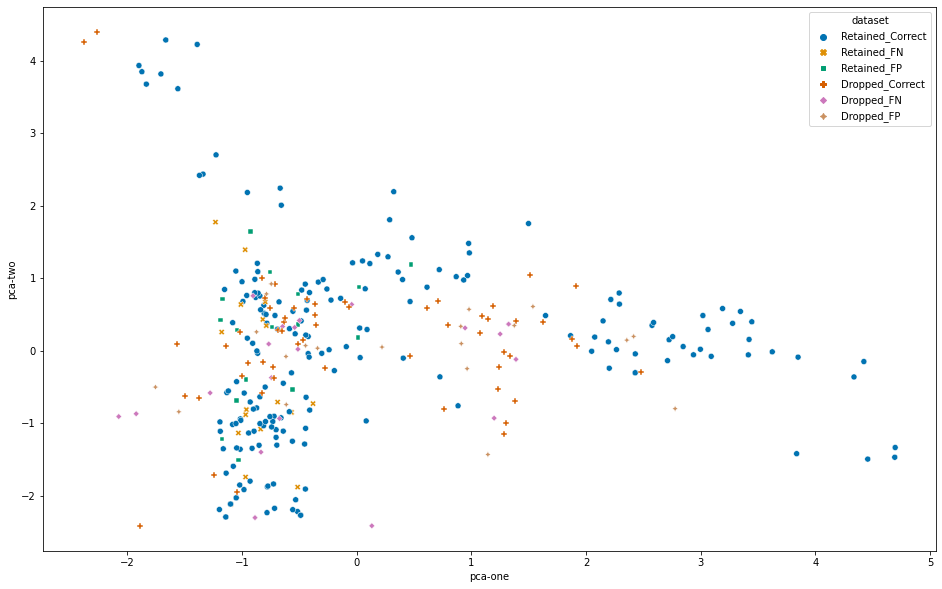

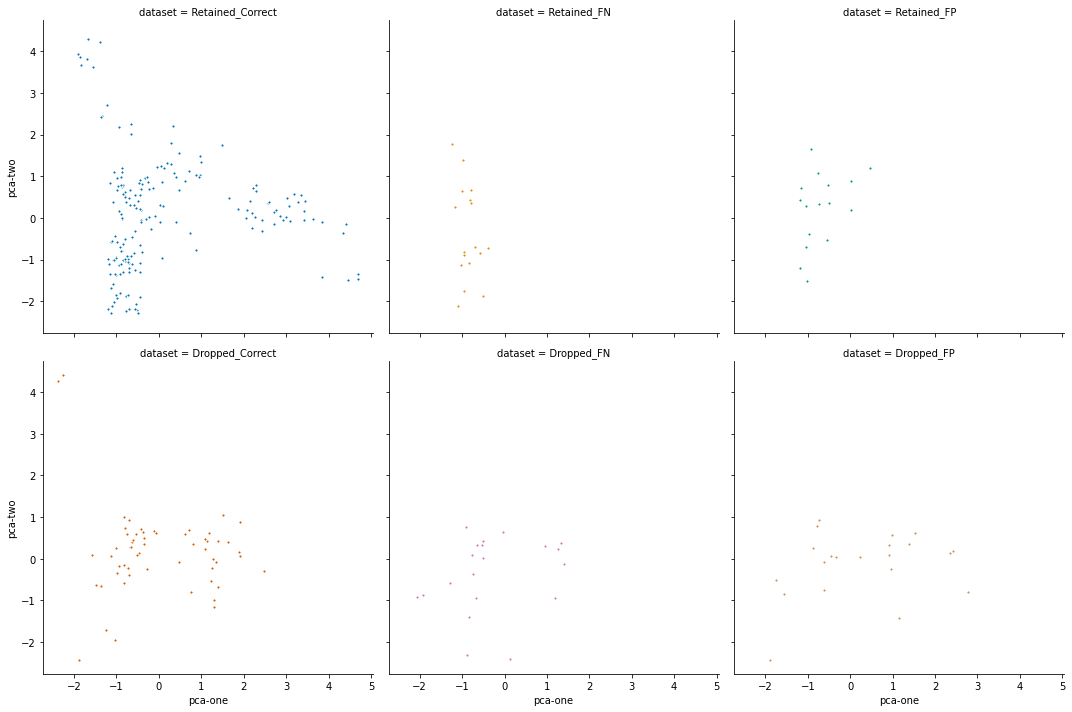


FINISHED


In [6]:
# Code for processing data files from above code

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import time

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#==============================================================================================#


# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls


#==============================================================================================#
#==============================================================================================#
# Functions
def input_to_tsne_plot(input_df,filename,perplex,iterations):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING t-SNE for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
#     input_df['SMILES'].replace('', np.nan, inplace=True)
#     input_df.dropna(subset=['SMILES'], inplace=True)
#     input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    input_df_smi = input_df['SMILES'].tolist()
    print('\ninput_df no. of SMILES:')
    print(len(input_df_smi))

    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
#     plot_data = plot_data.drop(error_idx_ls)
#     to_concat = to_concat.drop(error_idx_ls)
#     to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    tsne = TSNE(n_components=2, perplexity=perplex,n_iter=iterations,verbose=1)
    tsne_results = tsne.fit_transform(plot_data)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results,to_concat

def input_to_pca_plot(input_df,ref_df,remove_misclassified=False):
    # Data should only contain the feature columns ie. no label column
#     print('\n#=========================================================================================#')
#     print('\n                                      RUNNING PCA for                                       \n')
#     print('                             ' + str(filename) + '                             ')
#     print('\n')
#     print('#=========================================================================================#\n')
#     input_df['SMILES'].replace('', np.nan, inplace=True)
#     input_df.dropna(subset=['SMILES'], inplace=True)
#     input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    
    if remove_misclassified == True:
        input_df_smi = input_df['SMILES'].tolist()
        ref_df_smi = ref_df['SMILES'].tolist()

        print('\ninput_df no. of SMILES:')
        print(len(input_df_smi))

        print('\nref_df no. of SMILES:')
        print(len(ref_df_smi))

        input_df_smi = [x for x in input_df_smi if x not in ref_df_smi]

    if remove_misclassified == False:       
        input_df_smi = input_df['SMILES'].tolist()
        print('\ninput_df no. of SMILES:')
        print(len(input_df_smi))
    
    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
#     plot_data = plot_data.drop(error_idx_ls)
#     to_concat = to_concat.drop(error_idx_ls)
#     to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    pca = PCA(n_components = 2)
    pca_results = pca.fit_transform(plot_data)
    print('\nPercentage variance explained: {}'.format(pca.explained_variance_))
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return pca_results,to_concat

def tsne_main(root_desc,perplex,iterations):
    root = 'C:/Users/mwhw3/Desktop/DART project/'
    tsne_dict={}
    for filename in root_desc:
        index = root_desc.index(filename)

        input_df = pd.read_csv(input_path, sep=',')

        tsne_results,to_concat = input_to_tsne_plot(input_df,filename,perplex,iterations)

        tsne_df = pd.DataFrame(tsne_results, columns = ['tsne-2d-one','tsne-2d-two'])
        print(tsne_df.head())

        # Assign label for plotting later
        model_root_desc = 'V2.0.1 Reproductive toxicity'
        filepath = root + model_root_desc + '.csv'
        if filename == filepath:
            new_col = 'Reproductive toxicity'

        model_root_desc = 'V2.0.1 Developmental toxicity'    
        filepath = root + model_root_desc + '.csv'
        if filename == filepath:
            new_col = 'Developmental toxicity' 
                                
        else:
            new_col = 'Misclassified' 

        tsne_df = tsne_df.assign(dataset = new_col)    

        tsne_dict[new_col] = tsne_df
    
    return tsne_dict,to_concat

def pca_main(root_desc):
    root = 'C:/Users/mwhw3/Desktop/DART project/'
    pca_dict={}
    ref_filename = root_desc[1]
    ref_df = pd.read_csv(ref_filename, sep=',')
    for filename in root_desc:
        index = root_desc.index(filename)

        input_df = pd.read_csv(filename, sep=',')
                     
        # Assign label for plotting later
        if index==0 and model_root_desc == 'V2.0.1 Reproductive toxicity':            
            pca_results,to_concat = input_to_pca_plot(input_df,ref_df,filename,remove_misclassified=True)
            pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
            print(pca_df.head())
            
            new_col = 'Reproductive toxicity'
            pca_df = pca_df.assign(dataset = new_col)    

            pca_dict[new_col] = pca_df
            
            continue

        if index==0 and model_root_desc == 'V2.0.1 Developmental toxicity':
            pca_results,to_concat = input_to_pca_plot(input_df,ref_df,filename,remove_misclassified=True)
            pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
            print(pca_df.head())
            
            new_col = 'Developmental toxicity'             
            pca_df = pca_df.assign(dataset = new_col)    

            pca_dict[new_col] = pca_df
          
            continue
        
        if index==0 and model_root_desc == 'V2.0.1 Unified data':
            pca_results,to_concat = input_to_pca_plot(input_df,ref_df,filename,remove_misclassified=True)
            pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
            print(pca_df.head())
            
            new_col = 'entire dataset'             
            pca_df = pca_df.assign(dataset = new_col)    

            pca_dict[new_col] = pca_df
          
            continue
        
        else:
            pca_results,to_concat = input_to_pca_plot(input_df,ref_df,filename,remove_misclassified=False)
            pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
            print(pca_df.head())
            
            new_col = 'Misclassified' 

            pca_df = pca_df.assign(dataset = new_col)    

            pca_dict[new_col] = pca_df
    
    return pca_dict,to_concat

def consensus_pca_main(input_df_filename,dropped_df_filename):
    pca_dict={}

    dropped_df = pd.read_csv(dropped_df_filename)
    dropped_df = dropped_df[['SMILES', 'Binary Activity_x','FN count','FP count','consensus_y_pred_0','consensus_y_pred_1']]
    # Get consensus binary classification for dropped_df
    consensus_ls = []
    for row in range(0,len(dropped_df)):
        # Use majority voting for consensus prediction 
        if dropped_df.loc[row]['consensus_y_pred_1'] >= dropped_df.loc[row]['consensus_y_pred_0']:
            consensus_ls.append(1)
        else:
            consensus_ls.append(0)
    dropped_df['Consensus'] = consensus_ls
    
    input_df = pd.read_csv(input_df_filename)
    
    try:
        dropped_df = dropped_df[dropped_df.columns.drop(list(dropped_df.filter(regex='Unnamed')))]
    except:
        pass
    
    try:
        input_df = input_df[input_df.columns.drop(list(input_df.filter(regex='Unnamed')))]
    except:
        pass
    
    print('\nINPUT_DF\n')
    print(input_df)
    print('\nDROPPED_DF\n')
    print(dropped_df)
    
    input_pca_results,input_to_concat = input_to_pca_plot(input_df,dropped_df,remove_misclassified=False)
    input_pca_df = pd.DataFrame(input_pca_results, columns = ['pca-one','pca-two'])
    print(input_pca_df.head())

    dropped_pca_results,dropped_to_concat = input_to_pca_plot(dropped_df,dropped_df,remove_misclassified=False)
    dropped_pca_df = pd.DataFrame(dropped_pca_results, columns = ['pca-one','pca-two'])
    print(dropped_pca_df.head())
    

    
    return input_pca_df,input_to_concat,dropped_pca_df,dropped_to_concat
#======================================================================================#

# Set filepaths for functions

total_runs = 1

# Filename of model to load'
root = 'C:/Users/mwhw3/Desktop/DART project/'
model_root_desc = 'V2.0.1 Reproductive toxicity'
save_desc = 'V2.0.1 Reproductive toxicity run 1 V2 consensus misclassification analysis'
# input_path = root + model_root_desc + '.csv'
model_desc = model_root_desc + ' ' + str(total_runs)

# This the processed test df without any dropped rows
input_df_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 dropped rows misclassified predicted results.csv'

# This the df with dropped rows only
dropped_df_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 dropped rows only misclassified predicted results.csv'


#======================================================================================#
# Main code
# Filepaths of csv containing two columsn 'SMILES' and 'Binary Activity' to be input in
# root_desc as a list. This is for plotting t-SNE results of different datasets on the same plot

# Save location for resulting sns plot
plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne.tiff'
plot_save_pca = root + 'Feature plots/'+ save_desc + '_pca.tiff'
plot_save_pca_facet = root + 'Feature plots/'+ save_desc + '_pca_facet.tiff'


# Change tsne parameters
# Note perplexity is the guess of the number of nearest neighbours per data point

# perplex_ls = [10]
# perplex_ls = [10,20,40,60,80]
# iterations = 5000
# iterations = 1000
#==================================================================================#  
# # Plot data from specified feature visualisation method on the same axis

# For plotting tsne
# for perplex in perplex_ls:
#     print('\nRUNNING tsne with perplexity:',perplex)
#     tsne_dict,to_concat = tsne_main(root_desc,perplex,iterations)
#     tsne_concatenated = pd.concat(tsne_dict.values(), sort=False, ignore_index=False)
#     tsne_concatenated.columns= ['tsne-2d-one','tsne-2d-two','dataset']
#     plt.figure(figsize=(16,10))
#     sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=tsne_concatenated,
#                     hue='dataset', palette="colorblind", legend="full", style='dataset')

#     plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne_perplex' + str(perplex) + '.tiff'
#     plt.savefig(plot_save_tsne)
#     plt.show()

# For plotting PCA
input_pca_df,input_to_concat,dropped_pca_df,dropped_to_concat = consensus_pca_main(input_df_filename,
                                                                                   dropped_df_filename)

# Process dfs from consensus code and assign labels for plotting pca plots
# Plots should have original data w/o dropped data (misclassified + classified correctly)
# Total for this part should have 4 grids in the facet plots
# Also get labels for FN and FP for later plots
input_label_ls = []
for x in range(0,len(input_to_concat)):
    if input_to_concat.loc[x]['FN count'] == 24:
        input_label_ls.append('Retained_FN')
    elif input_to_concat.loc[x]['FP count'] == 24:
        input_label_ls.append('Retained_FP')
    else:
        input_label_ls.append('Retained_Correct')
input_pca_df['dataset'] = input_label_ls   


dropped_label_ls = []
for x in range(0,len(dropped_to_concat)):
    if dropped_to_concat.loc[x]['Consensus'] == dropped_to_concat.loc[x]['Binary Activity_x']:
        dropped_label_ls.append('Dropped_Correct')
    else:
        if dropped_to_concat.loc[x]['Binary Activity_x'] == 0 and dropped_to_concat.loc[x]['Consensus'] == 1:
            dropped_label_ls.append('Dropped_FP')
        else:
            dropped_label_ls.append('Dropped_FN')
dropped_pca_df['dataset'] = dropped_label_ls   
     

pca_concatenated = pd.concat([input_pca_df,dropped_pca_df],ignore_index=False)
pca_concatenated = pca_concatenated.reset_index(drop=True)
print(pca_concatenated)

future_analysis_df = pd.concat([input_pca_df,input_to_concat],axis=1)
future_analysis_df = future_analysis_df[['pca-one','pca-two','dataset','SMILES','consensus_y_pred_0',
                                        'consensus_y_pred_1','Consensus']]
temp_df = pd.concat([dropped_pca_df,dropped_to_concat],axis=1)
temp_df = temp_df[['pca-one','pca-two','dataset','SMILES','consensus_y_pred_0',
                  'consensus_y_pred_1','Consensus']]
print(temp_df)
future_analysis_df = pd.concat([future_analysis_df,temp_df],ignore_index=False)
future_analysis_df = future_analysis_df.reset_index(drop=True)
print('\nFUTURE ANALYSIS\n')
print(future_analysis_df)
future_analysis_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 future analysis for histogram misclassified predicted results.csv'
future_analysis_df.to_csv(future_analysis_save)

# pca_concatenated = pd.concat(pca_dict.values(), sort=False, ignore_index=False)  
# pca_concatenated.columns= ['pca-one','pca-two','dataset']

plt.figure(figsize=(16,10))
sns.scatterplot(x="pca-one", y="pca-two", data=pca_concatenated,
                hue='dataset', palette="colorblind", legend="full", style='dataset')

# Get tick labels for facet plot
# Remove first and last tick label which are the plot boundaries 
xticks = list(plt.xticks()[0])
xticks = [int(x) for x in xticks]
xticks = xticks[1:-1]

yticks = list(plt.yticks()[0])
yticks = [int(y) for y in yticks]
yticks = yticks[1:-1]
print(xticks)
print(yticks)

plt.savefig(plot_save_pca)
plt.show()

# Plot Facet grid for PCA plot to better visualise the global structure of the feature space
# This also enables the overlapping compounds to be visaulised better
plots_per_row = 3             # This controls how many plots appear in the Facet Grid plot per row
facet = sns.FacetGrid(pca_concatenated, col="dataset", col_wrap=plots_per_row, palette="colorblind", 
                      hue="dataset", height = 5)
facet = (facet.map(plt.scatter, "pca-one", "pca-two", s=10, edgecolor="w"))

facet.set(xticks=xticks, yticks=yticks)
plt.savefig(plot_save_pca_facet)
plt.show()

    
print('\nFINISHED')


INPUT DF

      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1     

C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


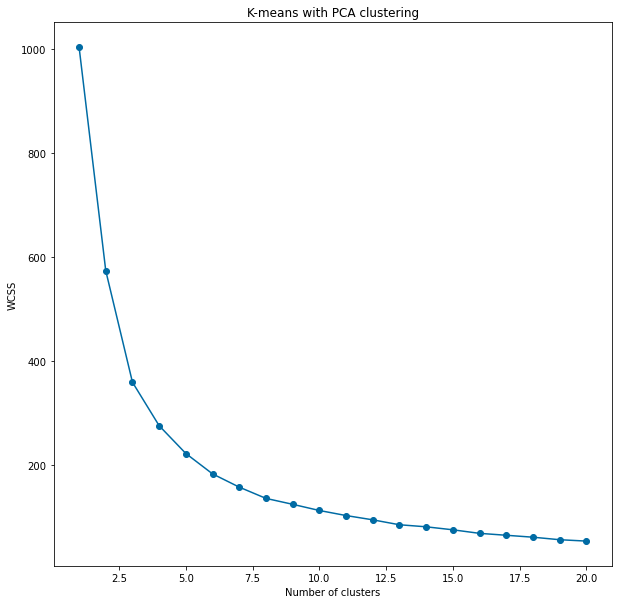

[[-1.33213155 -0.32138787]
 [ 0.22311058 -0.98880737]
 [ 1.31207079  1.38063757]
 [-1.20702938  1.19479297]
 [ 0.96547961  0.02740528]]
      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3          

In [52]:
# Code to cluster with kmeans from PCA plot

import pandas as pd
import numpy as np

import math
from math import sqrt

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG

from PIL import Image

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from numpy import unique
from numpy import where
#===================================================================================#
# Data
total_runs = 1
root = 'C:/Users/mwhw3/Desktop/DART project/'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'
model_desc = model_root_desc + ' ' + str(total_runs)
input_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 future analysis for histogram misclassified predicted results.csv'
# ' V2 future analysis misclassified predicted results.csv'

insert = ' Dropped only elbow_fig'
insert2 = ' Dropped only_fig'
kmeans_analysis_save = root + 'Feature plots/kmeans/' +  model_desc + ' V2 all K-means PCA misclassifion analysis.csv'

consensus_groupby_cluster_save = root + 'Feature plots/kmeans/' +  model_desc + ' V2 K-means distance groupby cluster misclassifion analysis.csv'
consensus_groupby_consensus_save = root + 'Feature plots/kmeans/' +  model_desc + ' V2 K-means distance groupby consensus_no misclassifion analysis.csv'

elbow_fig_filename = root + 'Feature plots/' +  model_desc + insert + ' V2 K-means PCA misclassifion analysis.tiff'
output_fig_all_filename = root + 'Feature plots/' +  model_desc + insert2 + ' all V2 K-means PCA misclassifion analysis.tiff'

initial_df = pd.read_csv(input_filename)

try:
    initial_df = initial_df[initial_df.columns.drop(list(initial_df.filter(regex='Unnamed')))]
except:
    pass
# print('INITIAL DF\n')
# print(initial_df)

# adjust rows of input_df to get desired pca plots
# input_df = initial_df[(initial_df.dataset == 'Dropped_FP') | (initial_df.dataset == 'Dropped_FN')| (initial_df.dataset == 'Dropped_Correct')]
# input_df = initial_df[(initial_df.dataset == 'Retained_FP') | (initial_df.dataset == 'Retained_FN')| (initial_df.dataset == 'Retained_Correct')]
input_df = initial_df
print('INPUT DF\n')
print(input_df)


# Clustering
# WCSS - Within cluster sum of squares
n_clusters = 20
wcss = []
for i in range(1,n_clusters+1):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state = 42)
    kmeans_pca.fit(input_df[['pca-one','pca-two']])
    wcss.append(kmeans_pca.inertia_)

# Plot graph to look for optimal cluster number using elbow method
plt.figure(figsize = (10,10))                        
plt.plot(range(1,n_clusters+1),wcss,marker='o',linestyle='-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA clustering')
# plt.savefig(elbow_fig_filename)
plt.show()

# Use optimal cluster number here
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state = 42)
kmeans_pca.fit(input_df[['pca-one','pca-two']])

# Print centroid coordinates/position
centroids = kmeans_pca.cluster_centers_
print(centroids)

kmeans_analysis_df = input_df.copy()
kmeans_analysis_df['Cluster'] = kmeans_pca.labels_
print(kmeans_analysis_df)
kmeans_analysis_df.to_csv(kmeans_analysis_save)

# Process kmeans_analysis_df for sum of squares of each data point (Euclidean distance)
# This is to see if a misclassified data point will be further away within a cluster
def calc_sum_of_squares(x,y,centroid_x,centroid_y):
    dist = sqrt(((x-centroid_x)**2)+((y-centroid_y)**2))
    return dist

SS = []
for x in range(0,len(kmeans_analysis_df)):
    cluster_no = kmeans_analysis_df.loc[x]['Cluster']
    centroid_coords = centroids[cluster_no]
    centroid_x = centroid_coords[0]
    centroid_y = centroid_coords[1]
    input_x = kmeans_analysis_df.loc[x]['pca-one']
    input_y = kmeans_analysis_df.loc[x]['pca-two']
#     print(input_x,input_y,centroid_x,centroid_y)
    SS.append(calc_sum_of_squares(input_x,input_y,centroid_x,centroid_y))

distance_analysis_df = kmeans_analysis_df.copy()
distance_analysis_df['sum of squares'] = SS
distance_analysis_df['Consensus_no'] = distance_analysis_df[['consensus_y_pred_0','consensus_y_pred_1']].max(axis=1)
distance_analysis_df = distance_analysis_df[['Consensus_no','Cluster','sum of squares']]
print('\nDISTANCE ANALYSIS')
print(distance_analysis_df)

# Groupby number of consensus models (Consensus_no)
# This calculates the mean sum of squares per consensus number
distance_groupby_cluster = distance_analysis_df.groupby(['Cluster','Consensus_no'])
print(distance_groupby_cluster.mean())
distance_groupby_cluster.mean().to_csv(consensus_groupby_cluster_save)
distance_analysis_df = distance_analysis_df[['Consensus_no','sum of squares']]
distance_groupby_consensus = distance_analysis_df.groupby(['Consensus_no'])
print(distance_groupby_consensus.mean())
distance_groupby_consensus.mean().to_csv(consensus_groupby_consensus_save)


# For 2D plots
# x_axis = kmeans_analysis_df['pca-one']
# y_axis = kmeans_analysis_df['pca-two']
# plt.figure(figsize = (10,8))    
# sns.scatterplot(x_axis, y_axis, hue = kmeans_analysis_df['Cluster no.'], palette = 'colorblind')
# plt.title('K-means clusters with PCA')
# plt.show()


# For 3D plots
# sns.set(style = "darkgrid")
def plot_cluster():
    fig = plt.figure(figsize = (12,8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.set_xlabel("pca-one")
    ax.set_ylabel("pca-two")
    ax.set_zlabel("Cluster")
    df = kmeans_analysis_df.copy()
    df.columns = ['pca_one','pca_two','dataset','SMILES','Cluster']
    # df = df[df.Cluster == 2]
    for s in df.dataset.unique():
        ax.scatter(df.pca_one[df.dataset==s],df.pca_two[df.dataset==s],df.Cluster[df.dataset==s],label=s)
    ax.legend()
    ax.view_init(20, -30)
    plt.style.use('tableau-colorblind10')
    # plt.savefig(output_fig_all_filename)
    plt.show()

# plot_cluster()    
    
# Another 3D plot to show certain cluster of data
def show_cluster(cluster_no):
    fig = plt.figure(figsize = (12,8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.set_xlabel("pca-one")
    ax.set_ylabel("pca-two")
    ax.set_zlabel("Cluster")
    ax.set_xticks(np.arange(-2, 3, 0.5))
    ax.set_yticks(np.arange(-2, 4, 0.5))
    ax.set_zticks(np.arange(0, 5, 0.5))
    df = kmeans_analysis_df.copy()
    df.columns = ['pca_one','pca_two','dataset','SMILES','Cluster']
    zoom_df = df[df.Cluster == cluster_no]
    for s in df.dataset.unique():
        ax.scatter(zoom_df.pca_one[zoom_df.dataset==s],zoom_df.pca_two[zoom_df.dataset==s],
                   zoom_df.Cluster[zoom_df.dataset==s],label=s)
    ax.legend()
    ax.view_init(20, -30)
    plt.style.use('tableau-colorblind10')
    output_fig_filename = root + 'Feature plots/' +  model_desc + insert2 + ' C' + str(cluster_no) + \
    ' V2 K-means PCA misclassifion analysis.tiff'
    plt.savefig(output_fig_filename)
    plt.show()

# for cluster_no in range(0,5):
#     show_cluster(cluster_no)


print('\nFINISHED')

In [100]:
# For calculating the average similarity per molecule for the 5 nearest neighbours in both the training and the test sets

import pandas as pd
import numpy as np


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit import DataStructs

from statistics import mean

#===================================================================================#
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,fingerprint_radius,nBits=nBits)
    
    return fp


#==============================================================================================#
def calc_Tanimoto_similarity(smiles1,smiles2):
    fp1 = get_Morgan_fingerprint(smiles1,2048,2)
    fp2 = get_Morgan_fingerprint(smiles2,2048,2)
    similarity = DataStructs.FingerprintSimilarity(fp1,fp2,metric=DataStructs.TanimotoSimilarity)
    
    return similarity

#===================================================================================#
# Data
total_runs = 1
root = 'C:/Users/mwhw3/Desktop/DART project/'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'
model_desc = model_root_desc + ' ' + str(total_runs)

input_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 future analysis for histogram misclassified predicted results.csv'

training_input_filename = root + 'AutoML models/' +  model_desc + \
'/Data/V2.0.1 Developmental toxicity 1 CSV train.csv'
# training_input_filename = root + 'AutoML models/' +  model_desc + \
# '/Data/V2.0.1 Reproductive toxicity 1 CSV train.csv'

kmeans_analysis_input = root + 'Feature plots/kmeans/' +  model_desc + ' V2 all K-means PCA misclassifion analysis.csv'

final_analysis_save = root + 'Similarities/' +  model_desc + \
' V2 training and test similarity pair analysis.csv'

merged_df_save = root + 'Similarities/' +  model_desc + \
' V2 merged training and test similarity pair analysis.csv'

# Sometimes csv saves but columns load incorrectly when opening with excel
# This mitigates the issue entierly by directly saving as xlsx
merged_df_save_xlsx = root + 'Similarities/' +  model_desc + \
' V2 merged training and test similarity pair analysis.xlsx'
#===================================================================================#

initial_df = pd.read_csv(input_filename)

try:
    initial_df = initial_df[initial_df.columns.drop(list(initial_df.filter(regex='Unnamed')))]
except:
    pass

kmeans_analysis_input_df = pd.read_csv(kmeans_analysis_input)

try:
    kmeans_analysis_input_df = kmeans_analysis_input_df[kmeans_analysis_input_df.columns.drop(list(kmeans_analysis_input_df.filter(regex='Unnamed')))]
except:
    pass
print(kmeans_analysis_input_df)

training_df = pd.read_csv(training_input_filename)

try:
    training_df = training_df[training_df.columns.drop(list(training_df.filter(regex='Unnamed')))]
except:
    pass
print('TRAINING DF\n')
print(training_df)


# adjust rows of input_df if necessary
# input_df = initial_df[(initial_df.dataset == 'Dropped_FP') | (initial_df.dataset == 'Dropped_FN')| (initial_df.dataset == 'Dropped_Correct')]
# input_df = initial_df[(initial_df.dataset == 'Retained_FP') | (initial_df.dataset == 'Retained_FN')| (initial_df.dataset == 'Retained_Correct')]

input_df = initial_df
print('INPUT DF\n')
print(input_df)

#===================================================================================#
# Get list of Tanimoto similarities per moelcule in the dataset
# test_smiles_df = input_df[['SMILES']]
training_smiles_df = training_df[['SMILES']]
smiles_df_ls = []

    # If calculating within training set
# for x in range(0,len(training_smiles_df)):
#     copy_df = training_smiles_df.copy()
#     copy_df = copy_df.drop([x], axis=0)

for x in range(0,len(test_smiles_df)):
    
    # If calculating between training and test set
    copy_df = training_smiles_df.copy()    
    
    # If calculating within test set
#     copy_df = test_smiles_df.copy()
#     copy_df = copy_df.drop([x], axis=0)
    
    # Calculate list of Tanimoto similarities
    similarity_ls = []
    smiles1 = test_smiles_df.loc[x]['SMILES']
#     smiles1 = training_smiles_df.loc[x]['SMILES']
    for index, row in copy_df.iterrows():
        smiles2 = row['SMILES']
        similarity_ls.append(calc_Tanimoto_similarity(smiles1,smiles2))
        if len(similarity_ls) % 150 == 0 and x % 100 == 0:
            print('\nNOW PROCESSING INDEX {} IN COPY_DF FOR MOLECULE {}'.format(index,x))
            print(len(similarity_ls),'SIMILARITY PAIRS CALCULATED')
    smiles_df_ls.append(similarity_ls)
        
final_analysis_df = input_df.copy()
# final_analysis_df = training_smiles_df.copy()
final_analysis_df['similarity'] = smiles_df_ls
final_analysis_df = final_analysis_df[['SMILES','similarity']]
# print(final_analysis_df)
final_analysis_df.to_csv(final_analysis_save)

# Merge cluster information from kmeans with similarity
merged_df = kmeans_analysis_input_df.merge(final_analysis_df, on="SMILES", how="inner")
# merged_df = final_analysis_df.copy()

# Get average similarity and average of top 1,3,5 similarity per compound
average_sim = []
top_1 = []
top_3 = []
top_5 = []

for index, row in merged_df.iterrows():
    to_process = row['similarity']
    to_process = sorted(to_process, reverse=True)
    
    average_sim.append(mean(to_process))
    top_1.append(to_process[0])
    top_3.append(mean(to_process[0:3]))
    top_5.append(mean(to_process[0:5]))
    
    
merged_df['average_sim'] = average_sim
merged_df['top_1'] = top_1
merged_df['top_3'] = top_3
merged_df['top_5'] = top_5

print('\nMERGED')
print(merged_df)
merged_df.to_csv(merged_df_save,sep=';')

print('\nFINISHED')

      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1               

In [101]:
print(merged_df)
# merged_df_save_xlsx = root + 'Similarities/' +  model_desc + \
# ' V2 merged within training similarity pair analysis.xlsx'
# merged_df.to_csv(merged_df_save,sep=';')
merged_df.to_excel(merged_df_save_xlsx, index=True)

      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1               

In [102]:
# Process merged_df if doing train test pairs to get top similar structure in training set
merged_df_save2 = root + 'Similarities/' +  model_desc + \
' V2 sorted merged training and test similarity pair analysis.csv'

# merged_smiles_ls = input_df['SMILES']
merged_smiles_ls = training_df['SMILES']
print(len(merged_smiles_ls))
sorted_SMILES = []
sorted_similarity = []
for index,row in merged_df.iterrows():
    to_sort = row['similarity']
#     print(to_sort)
    # Get top 5 indices and values for similarity pairs
    sorted_tuple = sorted(enumerate(to_sort), reverse=True, key=lambda x: x[1])[:5]
#     print(sorted_tuple)
    indices,value = [list(ele) for ele in zip(*sorted_tuple)]
#     index = [index for index, value in sorted(enumerate(to_sort), reverse=True, key=lambda x: x[1])[:6]
             
    # Get corresponding SMILES as list
#     print(indices)
#     print(value)
    temp = [merged_smiles_ls[i] for i in indices]  
    sorted_SMILES.append(temp)
    sorted_similarity.append(value)
    
merged_df['sorted_SMILES'] = sorted_SMILES
merged_df['sorted_similarity'] = sorted_similarity
                   
print('\nMERGED')
print(merged_df)
merged_df.to_csv(merged_df_save2)

merged_df_save_xlsx2 = root + 'Similarities/' +  model_desc + \
' V2 sorted merged training and test similarity pair analysis.xlsx'
merged_df.to_excel(merged_df_save_xlsx2, index=True)
print('\nFINISHED')

1779

MERGED
      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1  

INITIAL DF

      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1   

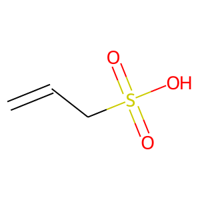

CCCCCCCCC


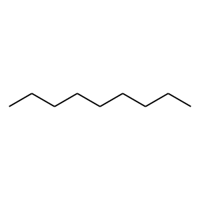

OC1CCCCC1


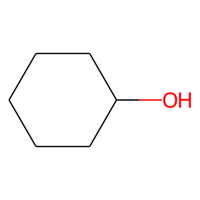


DF STATS FOR CLUSTER:  1
                  dataset
Retained_Correct       42
Dropped_Correct        35
Dropped_FN             15
Retained_FP            13
Retained_FN            10
Dropped_FP              7

DF FOR CLUSTER:  1
      pca-one   pca-two           dataset  \
1    0.083917 -0.751879  Retained_Correct   
9   -0.153003 -1.115271  Retained_Correct   
14   0.604709 -0.942444  Retained_Correct   
17   0.110476 -0.555948  Retained_Correct   
20  -0.183259 -0.426532       Retained_FN   
..        ...       ...               ...   
429  0.173685 -1.477351   Dropped_Correct   
434  0.360120 -0.786074   Dropped_Correct   
438  0.514719 -0.598634        Dropped_FP   
440  0.798673 -0.807198   Dropped_Correct   
443 -0.250589 -1.264948   Dropped_Correct   

                                                SMILES  consensus_y_pred_0  \
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
9                CCCCC(CN1C=NC=N1)(C#N)C1=CC=C(Cl)C=C1                   0 

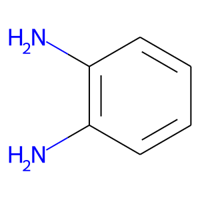

CN1COCN(CC2=CN=C(Cl)S2)C1=N[N+]([O-])=O


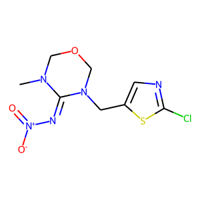

N1C2=C(C=CC=C2)N=C1C1=CSC=N1


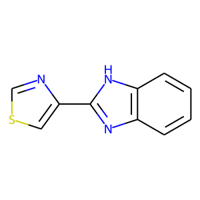

CN=C1C=NN(C2=CC=CC(=C2)C(F)(F)F)C(=O)C1Cl


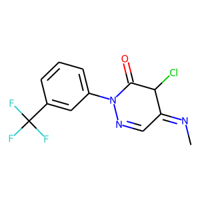


DF STATS FOR CLUSTER:  2
                  dataset
Retained_Correct       26
Dropped_Correct        10
Dropped_FN              8
Dropped_FP              6
Retained_FP             3

DF FOR CLUSTER:  2
      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
18   1.957215  0.843974       Retained_FP   
31   1.491808  1.555686  Retained_Correct   
38   2.638923  1.127704  Retained_Correct   
54   1.183021  1.636007  Retained_Correct   
59   1.111905  2.401148  Retained_Correct   
60   1.153915  1.498573  Retained_Correct   
66   1.935119  1.489508  Retained_Correct   
67   1.176726  1.293635  Retained_Correct   
93   0.737724  1.030872  Retained_Correct   
103  0.552456  0.921006  Retained_Correct   
106  0.457656  2.173729       Retained_FP   
110  2.432820  1.445569  Retained_Correct   
112  0.904111  1.329701  Retained_Correct   
130  0.308920  1.485872  Retained_Correct   
133  0.734142  1.622138  Retained_Correct   
136  0.340319  1.068258  Retained

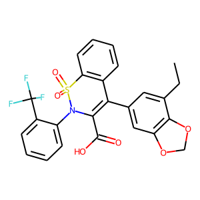


DF STATS FOR CLUSTER:  3
                  dataset
Retained_Correct       28
Dropped_Correct        19
Dropped_FP              8
Dropped_FN              5
Retained_FP             2
Retained_FN             1

DF FOR CLUSTER:  3
      pca-one   pca-two           dataset  \
7   -0.386477  1.355356  Retained_Correct   
8   -1.459516  0.920361  Retained_Correct   
10  -1.447254  0.771084  Retained_Correct   
16  -1.728202  0.922581  Retained_Correct   
21  -0.081931  1.095010  Retained_Correct   
..        ...       ...               ...   
411 -0.855279  2.667514        Dropped_FP   
413 -1.146651  1.118501        Dropped_FP   
420 -1.273254  1.511069   Dropped_Correct   
426 -1.007387  0.634130        Dropped_FP   
441 -0.204978  2.051749   Dropped_Correct   

                                             SMILES  consensus_y_pred_0  \
7                          CC(CS)C(=O)N1CCCC1C(O)=O                   0   
8                                    COCC(C)OC(C)=O                  24   
10    

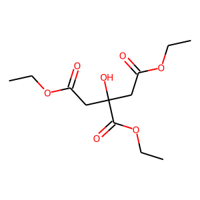


DF STATS FOR CLUSTER:  4
                  dataset
Retained_Correct       44
Dropped_Correct        31
Dropped_FN             14
Dropped_FP              9
Retained_FN             8
Retained_FP             5

DF FOR CLUSTER:  4
      pca-one   pca-two           dataset  \
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
5    1.062014  0.387518  Retained_Correct   
6    1.827932 -0.717198  Retained_Correct   
..        ...       ...               ...   
427  0.560824 -0.331304        Dropped_FN   
428  1.764330 -0.988543        Dropped_FP   
431  1.852283  0.071495        Dropped_FN   
437  0.596632 -0.238501   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0 

In [58]:
# For drawing structures in clusters based on criteria
import pandas as pd
import numpy as np

import os

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG

from PIL import Image
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from numpy import unique
from numpy import where
#===================================================================================#
# Data
total_runs = 1
n_clusters = 5
root = 'C:/Users/mwhw3/Desktop/DART project/'
# toxicity = 'Reproductive toxicity'
toxicity = 'Developmental toxicity'
model_root_desc = 'V2.0.1 '+ toxicity
model_desc = model_root_desc + ' ' + str(total_runs)
# input_filename = root + 'Feature plots/kmeans/' +  model_desc + ' V2 all K-means PCA misclassifion analysis.csv'
input_filename = root + 'Similarities/' +  model_desc + \
' V2 merged similarity analysis.csv'
#===================================================================================#
initial_df = pd.read_csv(input_filename)
try:
    initial_df = initial_df[initial_df.columns.drop(list(initial_df.filter(regex='Unnamed')))]
except:
    pass
print('INITIAL DF\n')
print(initial_df)
# query_ls = list(initial_df['dataset'].unique())

# Create folders for dropped and retained for each toxicity
dir_path = root + 'Mols images/'+ toxicity +'Retained_classification/'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

dir_path = root + 'Mols images/'+ toxicity +'Dropped_classification/'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

def make_cluster_dirs(classification,cluster):
    # Create new folders if it doesn't exist to store mols images
    # Main folder per cluster  
    
    cluster_dir_path = root + 'Mols images/'+ toxicity + classification + '/Cluster_' + str(cluster) + '/'
    if not os.path.exists(cluster_dir_path):
        os.makedirs(cluster_dir_path)
        
    # Create two more folders to store FN and FN mols images
    FNpath = root + 'Mols images/'+ toxicity + classification + '/Cluster_' + str(cluster) + '/' + 'FN/'
    if not os.path.exists(FNpath):
        os.makedirs(FNpath)
        
    FPpath = root + 'Mols images/'+ toxicity + classification + '/Cluster_' + str(cluster) + '/' + 'FP/'
    if not os.path.exists(FPpath):
        os.makedirs(FPpath)
    
    Correctpath = root + 'Mols images/'+ toxicity + classification + '/Cluster_' + str(cluster) + '/' + 'Correct/'
    if not os.path.exists(Correctpath):
        os.makedirs(Correctpath)
    
    return

def set_cluster_dirs(cluster):       
    Dropped_FNpath = root + 'Mols images/'+ toxicity + 'Dropped_classification/Cluster_' + str(cluster) + '/' + 'FN/'        
    Dropped_FPpath = root + 'Mols images/'+ toxicity + 'Dropped_classification/Cluster_' + str(cluster) + '/' + 'FP/'    
    Dropped_Correctpath = root + 'Mols images/'+ toxicity + 'Dropped_classification/Cluster_' + str(cluster) + '/' + 'Correct/'    
     
    Retained_FNpath = root + 'Mols images/'+ toxicity + 'Retained_classification/Cluster_' + str(cluster) + '/' + 'FN/'        
    Retained_FPpath = root + 'Mols images/'+ toxicity + 'Retained_classification/Cluster_' + str(cluster) + '/' + 'FP/'    
    Retained_Correctpath = root + 'Mols images/'+ toxicity + 'Retained_classification/Cluster_' + str(cluster) + '/' + 'Correct/'        
    
    return Dropped_FNpath,Dropped_FPpath,Dropped_Correctpath,Retained_FNpath,Retained_FPpath,Retained_Correctpath
    
for cluster in range(0,n_clusters):
    df = initial_df[initial_df.Cluster == cluster]
    new_df = pd.DataFrame(df['dataset'].value_counts())
    print('\nDF STATS FOR CLUSTER: ',cluster)
    print(new_df)

    make_cluster_dirs('Retained_classification',cluster)
    make_cluster_dirs('Dropped_classification',cluster)
    
    Dropped_FNpath,Dropped_FPpath,Dropped_Correctpath,Retained_FNpath,Retained_FPpath,Retained_Correctpath = set_cluster_dirs(cluster)
        
    # Drawing mols
    print('\nDF FOR CLUSTER: ',cluster)
#     query_df = df.reset_index(drop=True)
    query_df = df.copy()
    print(query_df)
    
    for index, row in query_df.iterrows():
        query_smiles = row['SMILES']

        m = Chem.MolFromSmiles(query_smiles,sanitize=True)
#         m.UpdatePropertyCache(strict=False)
        img = Draw.MolToImage(m,kekulize=True)
        img = img.resize((200,200))
        
        if row['dataset'] == 'Dropped_FN':
            img_savepath = Dropped_FNpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
        if row['dataset'] == 'Dropped_FP':
            img_savepath = Dropped_FPpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
        if row['dataset'] == 'Dropped_Correct':
            img_savepath = Dropped_Correctpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
            
        if row['dataset'] == 'Retained_FN':
            img_savepath = Retained_FNpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
        if row['dataset'] == 'Retained_FP':
            img_savepath = Retained_FPpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
        if row['dataset'] == 'Retained_Correct':
            img_savepath = Retained_Correctpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)        
        
        if index % 50 == 0:
            print(query_smiles)
            display(img)

print('\nFINISHED')

In [122]:
# Code for plotting histogram

import pandas as pd
import numpy as np

import seaborn as sns

from IPython.display import SVG

from PIL import Image

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


#===================================================================================#
# Data
total_runs = 1
root = 'C:/Users/mwhw3/Desktop/DART project/'
# model_root_desc = 'V2.0.1 Reproductive toxicity'
model_root_desc = 'V2.0.1 Developmental toxicity'
model_desc = model_root_desc + ' ' + str(total_runs)
input_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 future analysis for histogram misclassified predicted results.csv'

count_df_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 dropped rows count.xlsx'


initial_df = pd.read_csv(input_filename)
try:
    initial_df = initial_df[initial_df.columns.drop(list(initial_df.filter(regex='Unnamed')))]
except:
    pass



#===================================================================================#
initial_df = initial_df[['dataset','consensus_y_pred_0','consensus_y_pred_1']]
input_df = initial_df[(initial_df.dataset == 'Dropped_FP') | (initial_df.dataset == 'Dropped_FN')| (initial_df.dataset == 'Dropped_Correct')]

# get model_count column for histogram
model_count_ls = []

def model_count(row):
    if row['consensus_y_pred_1'] >= row['consensus_y_pred_0']:
        return row['consensus_y_pred_1']
    else:
        return -row['consensus_y_pred_0']

def plot_hist():
    sns.set()

    fig = sns.histplot(data = initial_df
                ,x = 'model_count'
                ,palette ='colorblind' 
                ,alpha = .7
                ,hue = 'dataset'
                ,binwidth = 1
                ,multiple="stack"
                ,discrete = True
                )

    output_fig_filename = root + 'Feature plots/' +  model_desc +  \
    ' V2 histogram misclassified predicted results.tiff'
    plt.savefig(output_fig_filename)
    plt.show()

def absolute_count(row):
    return int(abs(row['model_count']))

input_df['model_count'] = input_df.apply(model_count, axis=1)
input_df['absolute_model_count'] = input_df.apply(absolute_count, axis=1)
print(input_df)
print(len(input_df)/len(initial_df)*100)

no_of_models_ls = []
count_ls = []
for no_of_models in range(12,25):
    count = 0
    
    for index,row in input_df.iterrows():
        if int(row['absolute_model_count']) < no_of_models:
            count += 1
            
    count_ls.append(count)
    no_of_models_ls.append(no_of_models)
    
count_df = pd.DataFrame(no_of_models_ls,columns=['no_of_models'])
count_df['dropped_row_count'] = count_ls
print(count_df)
count_df.to_excel(count_df_save)
    
print('\nFINISHED')

             dataset  consensus_y_pred_0  consensus_y_pred_1  model_count  \
231  Dropped_Correct                   3                  21           21   
232  Dropped_Correct                   7                  17           17   
233  Dropped_Correct                  16                   8          -16   
234       Dropped_FN                  22                   2          -22   
235  Dropped_Correct                   1                  23           23   
..               ...                 ...                 ...          ...   
440  Dropped_Correct                   1                  23           23   
441  Dropped_Correct                  10                  14           14   
442       Dropped_FP                   1                  23           23   
443  Dropped_Correct                   1                  23           23   
444       Dropped_FN                  16                   8          -16   

     absolute_model_count  
231                    21  
232                

C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Code to construct feature plots for misclassified data only. This will show the distinction between the false positive and false negative compounds. The code will also count the number of false positives and false negatives across all runs and group them.


#=========================================================================================#

                                      RUNNING PCA for                                       

                             C:/Users/mwhw3/Desktop/DART project/AutoML models combined interpreting predicted results/V2.0.1 Unified data 5 misclassified predicted results.csv                             


#=========================================================================================#


input_df no. of SMILES:
658
658
   0     1     2     3     4     5     6     7     8     9     ...  2038  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     1     0     0     0     0     0     0     0     0  ...     0   

   2039  2040  2041  

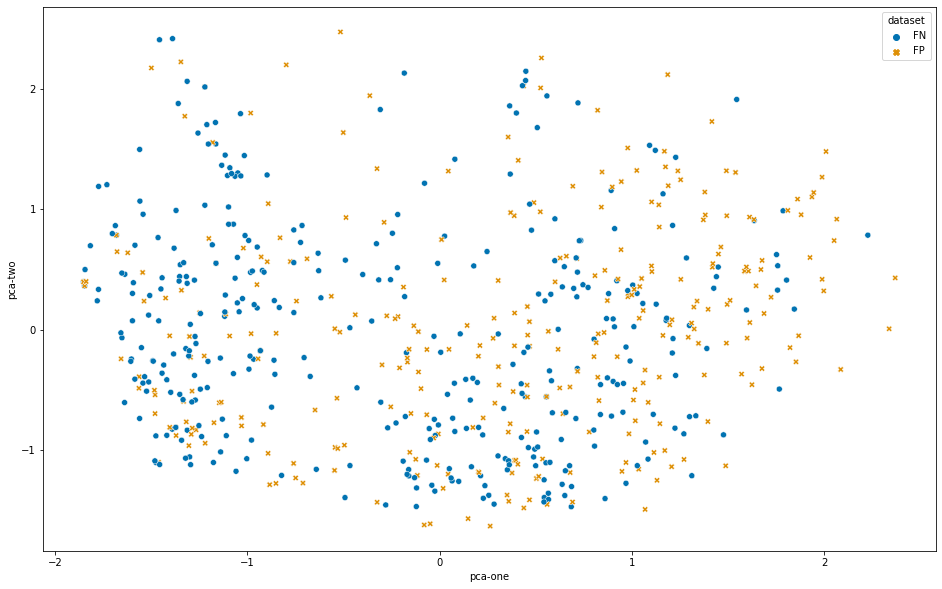

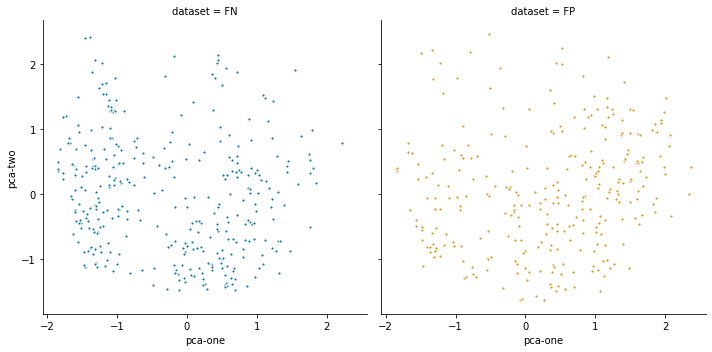


FINISHED


In [123]:
# Code for processing data files from above code

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import time

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#==============================================================================================#


# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls


#==============================================================================================#
#==============================================================================================#
# Functions
def input_to_tsne_plot(input_df,filename,perplex,iterations):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING t-SNE for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
#     input_df['SMILES'].replace('', np.nan, inplace=True)
#     input_df.dropna(subset=['SMILES'], inplace=True)
#     input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    input_df_smi = input_df['SMILES'].tolist()
    print('\ninput_df no. of SMILES:')
    print(len(input_df_smi))

    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
#     plot_data = plot_data.drop(error_idx_ls)
#     to_concat = to_concat.drop(error_idx_ls)
#     to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    tsne = TSNE(n_components=2, perplexity=perplex,n_iter=iterations,verbose=1)
    tsne_results = tsne.fit_transform(plot_data)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results,to_concat

def input_to_pca_plot(input_df,filename,remove_misclassified=False):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING PCA for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
#     input_df['SMILES'].replace('', np.nan, inplace=True)
#     input_df.dropna(subset=['SMILES'], inplace=True)
#     input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    
    if remove_misclassified == True:
        input_df_smi = input_df['SMILES'].tolist()
        ref_df_smi = ref_df['SMILES'].tolist()

        print('\ninput_df no. of SMILES:')
        print(len(input_df_smi))

        print('\nref_df no. of SMILES:')
        print(len(ref_df_smi))

        input_df_smi = [x for x in input_df_smi if x not in ref_df_smi]

    if remove_misclassified == False:       
        input_df_smi = input_df['SMILES'].tolist()
        print('\ninput_df no. of SMILES:')
        print(len(input_df_smi))
    
    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
#     plot_data = plot_data.drop(error_idx_ls)
#     to_concat = to_concat.drop(error_idx_ls)
#     to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    pca = PCA(n_components = 2)
    pca_results = pca.fit_transform(plot_data)
    print('\nPercentage variance explained: {}'.format(pca.explained_variance_))
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return pca_results,to_concat

def tsne_main(root_desc,perplex,iterations):
    root = 'C:/Users/mwhw3/Desktop/DART project/'
    tsne_dict={}
    for filename in root_desc:
        index = root_desc.index(filename)

        input_df = pd.read_csv(input_path, sep=',')

        tsne_results,to_concat = input_to_tsne_plot(input_df,filename,perplex,iterations)

        tsne_df = pd.DataFrame(tsne_results, columns = ['tsne-2d-one','tsne-2d-two'])
        print(tsne_df.head())

        # Assign label for plotting later
        model_root_desc = 'V2.0.1 Reproductive toxicity'
        filepath = root + model_root_desc + '.csv'
        if filename == filepath:
            new_col = 'Reproductive toxicity'

        model_root_desc = 'V2.0.1 Developmental toxicity'    
        filepath = root + model_root_desc + '.csv'
        if filename == filepath:
            new_col = 'Developmental toxicity' 
                                
        else:
            new_col = 'Misclassified' 

        tsne_df = tsne_df.assign(dataset = new_col)    

        tsne_dict[new_col] = tsne_df
    
    return tsne_dict,to_concat

def pca_main(root_desc):
    root = 'C:/Users/mwhw3/Desktop/DART project/'
    for filename in root_desc:
        input_df = pd.read_csv(filename, sep=',')

        # Assign label for plotting later

        pca_results,to_concat = input_to_pca_plot(input_df,filename,remove_misclassified=False)
        pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
        print(pca_df.head())

        # Process to_concat for labels and to get counts of FP and FN

        overall_label = []
        overall_label.clear()

        to_concat = to_concat.drop(columns=['Unnamed: 0'])      
        
        # Add new column counting number of misclassifications
        # Subtract 1 becasue of SMILES column
        to_concat['Misclass count'] = to_concat.count(axis=1).subtract(1) 
            
        # Add new column for overall label of compound 
        for x in range(0,len(to_concat)):
            query_row = to_concat.loc[x]
            FN_count = (query_row == "FN").sum()
            FP_count = (query_row == "FP").sum()
            
            if FP_count > FN_count:
                overall_label.append('FP')
            
            if FN_count > FP_count:
                overall_label.append('FN')
            
            if FP_count == FN_count:
                overall_label.append('inconclusive')                
             
            
        to_concat['Overall label'] = overall_label
    

        
        pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
        pca_df['dataset'] = overall_label

    return pca_df,to_concat

#======================================================================================#

# Set filepaths for functions

total_runs = 5

# Filename of model to load'
root = 'C:/Users/mwhw3/Desktop/DART project/'
model_root_desc = 'V2.0.1 Unified data'
save_desc = 'V2.0.1 Unified data FP and FN analysis'
input_path = root + model_root_desc + '.csv'
model_desc = model_root_desc + ' ' + str(total_runs)
ref_df = root + 'AutoML models combined interpreting predicted results/' +  model_desc + ' misclassified predicted results.csv'

# overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
# str(total_runs) +' runs interpreting predicted results.csv'
analysis_save_desc = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
' ' + str(total_runs) +' runs processed FN and FP results.csv'
for_PCA_extraction_save_desc = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
' ' + str(total_runs) +' runs for PCA extraction processed FN and FP results.csv'


#======================================================================================#
# Main code
# Filepaths of csv containing two columsn 'SMILES' and 'Binary Activity' to be input in
# root_desc as a list. This is for plotting t-SNE results of different datasets on the same plot

root_desc = [ref_df]

# Save location for resulting sns plot
plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne.tiff'
plot_save_pca = root + 'Feature plots/'+ save_desc + '_pca.tiff'
plot_save_pca_facet = root + 'Feature plots/'+ save_desc + '_pca_facet.tiff'


# Change tsne parameters
# Note perplexity is the guess of the number of nearest neighbours per data point

# perplex_ls = [10]
perplex_ls = [10,20,40,60,80]
# iterations = 5000
iterations = 1000
#==================================================================================#  
# # Plot data from specified feature visualisation method on the same axis

# For plotting tsne
# for perplex in perplex_ls:
#     print('\nRUNNING tsne with perplexity:',perplex)
#     tsne_dict,to_concat = tsne_main(root_desc,perplex,iterations)
#     tsne_concatenated = pd.concat(tsne_dict.values(), sort=False, ignore_index=False)
#     tsne_concatenated.columns= ['tsne-2d-one','tsne-2d-two','dataset']
#     plt.figure(figsize=(16,10))
#     sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=tsne_concatenated,
#                     hue='dataset', palette="colorblind", legend="full", style='dataset')

#     plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne_perplex' + str(perplex) + '.tiff'
#     plt.savefig(plot_save_tsne)
#     plt.show()

# For plotting PCA
pca_df,to_concat = pca_main(root_desc)
print(to_concat)
to_concat.to_csv(analysis_save_desc)

for_extraction_df = pd.concat([pca_df,to_concat],axis=1)
for_extraction_df.to_csv(for_PCA_extraction_save_desc)

plt.figure(figsize=(16,10))
sns.scatterplot(x="pca-one", y="pca-two", data=pca_df,
                hue='dataset', palette="colorblind", legend="full", style='dataset')

# Get tick labels for facet plot
# Remove first and last tick label which are the plot boundaries 
xticks = list(plt.xticks()[0])
xticks = [int(x) for x in xticks]
xticks = xticks[1:-1]

yticks = list(plt.yticks()[0])
yticks = [int(y) for y in yticks]
yticks = yticks[1:-1]
print(xticks)
print(yticks)

plt.savefig(plot_save_pca)
plt.show()

# Plot Facet grid for PCA plot to better visualise the global structure of the feature space
# This also enables the overlapping compounds to be visaulised better
plots_per_row = 2             # This controls how many plots appear in the Facet Grid plot per row
facet = sns.FacetGrid(pca_df, col="dataset", col_wrap=plots_per_row, palette="colorblind", 
                      hue="dataset", height = 5)
facet = (facet.map(plt.scatter, "pca-one", "pca-two", s=10, edgecolor="w"))

facet.set(xticks=xticks, yticks=yticks)
plt.savefig(plot_save_pca_facet)
plt.show()

    
print('\nFINISHED')


continue to extract selected compounds for drawing/presentation

7
pca-one                                   1.403379
pca-two                                  -0.627391
SMILES           ClC1=NC=CC(NC(=O)NC2=CC=CC=C2)=C1
Overall label                                   FP
Name: 7, dtype: object


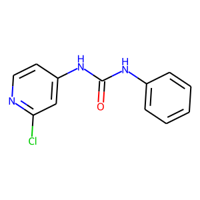

In [122]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG

from PIL import Image

for_extraction_df = for_extraction_df[['pca-one', 'pca-two', 'SMILES', 'Overall label']]
#print(for_extraction_df)

# Extract selected compounds
# Input PCA as boundaries
# Code will pick one of the middle compounds within the specified boundaries
def extract_PCA(PCA_one_left, PCA_one_right, PCA_two_top, PCA_two_bottom,query_label,img_savepath):
    query_df = for_extraction_df.loc[(for_extraction_df["pca-one"] >= PCA_one_left) & (for_extraction_df["pca-one"] <= PCA_one_right) \
                                     & (for_extraction_df["pca-two"] <= PCA_two_top) & (for_extraction_df["pca-two"] >= PCA_two_bottom) \
                                     & (for_extraction_df['Overall label'] == query_label)]

    sorted_query_df = query_df.sort_values(['pca-one', 'pca-two'])
    sorted_query_df = sorted_query_df.reset_index(drop=True)
    
    # -1 because index starts from 0
    mid_row = int(len(sorted_query_df)/2)   
    print(mid_row)
    print(sorted_query_df.iloc[mid_row])
    
    query_smiles = sorted_query_df.iloc[mid_row]['SMILES']
    
    m = Chem.MolFromSmiles(query_smiles,sanitize=False)
    m.UpdatePropertyCache(strict=False)
    img = Draw.MolToImage(m,kekulize=True)
    img = img.resize((200,200))
    img.save(img_savepath)
    display(img)
    
    return
    
# Note not to specify too precise/exact values because of python float rounding issues
PCA_one_left = 0.9   
PCA_one_right = 2 
PCA_two_top = 0
PCA_two_bottom = -0.85
root = 'C:/Users/mwhw3/Desktop/DART project/AutoML models combined interpreting predicted results/'
img_savepath = root + 'reprotox selected FP compounds/' + 'example' + str(3) + '.png'
extract_PCA(PCA_one_left, PCA_one_right, PCA_two_top, PCA_two_bottom, 'FP', img_savepath)
    

code to count number of fp or fn, dev or repro tox in unified data 

In [140]:
# Code for processing data files from above code

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import time

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#==============================================================================================#


# Set filepaths for functions

total_runs = 5

# Filename of model to load'
root = 'C:/Users/mwhw3/Desktop/DART project/'
ref_root_desc = 'V2.0.1 Unified data'
ref_desc = ref_root_desc + ' ' + str(total_runs)
ref_df_filename = root + 'AutoML models combined interpreting predicted results/' +  ref_desc + ' runs processed FN and FP results.csv'
ref_df = pd.read_csv(ref_df_filename)
if 'Unnamed: 0' in (ref_df.columns):
    ref_df = ref_df.drop(columns=['Unnamed: 0'])
print(ref_df)

dev_tox_filename = root + 'V2.0.1 Developmental toxicity' + '.csv'
dev_tox_df = pd.read_csv(dev_tox_filename)
print(dev_tox_df)

repro_tox_filename = root + 'V2.0.1 Reproductive toxicity' + '.csv'
repro_tox_df = pd.read_csv(repro_tox_filename)
print(repro_tox_df)

# overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
# str(total_runs) +' runs interpreting predicted results.csv'
misclassified_stats_save_desc = root + 'AutoML models combined interpreting predicted results/' + ref_root_desc + \
' ' + str(total_runs) +' runs processed misclassified stats.csv'

#======================================================================================#

# Main code
tox_ls = []
tox_ls.clear()

dev_tox_FN_count = 0
dev_tox_FP_count = 0

repro_tox_FN_count = 0
repro_tox_FP_count = 0

unclear_FN_count = 0
unclear_FP_count = 0

stats_ls = []
stats_ls.clear()

for x in range(0,len(ref_df)):
    query_smiles = ref_df.iloc[x]['SMILES']
    
#     if (query_smiles in dev_tox_df['SMILES']):
    if (query_smiles in dev_tox_df['SMILES'].values) and (query_smiles not in repro_tox_df['SMILES'].values):
        tox_ls.append('Devtox')
        if ref_df.iloc[x]['Overall label'] == 'FN':
            dev_tox_FN_count += 1
        if ref_df.iloc[x]['Overall label'] == 'FP':
            dev_tox_FP_count += 1
        
#     if (query_smiles in repro_tox_df['SMILES']):
    if (query_smiles in repro_tox_df['SMILES'].values) and (query_smiles not in dev_tox_df['SMILES'].values):
        tox_ls.append('Reprotox')
        if ref_df.iloc[x]['Overall label'] == 'FN':
            repro_tox_FN_count += 1
        if ref_df.iloc[x]['Overall label'] == 'FP':
            repro_tox_FP_count += 1      
        
    else:    
        tox_ls.append('Unclear')
        if ref_df.iloc[x]['Overall label'] == 'FN':
            unclear_FN_count += 1
        if ref_df.iloc[x]['Overall label'] == 'FP':
            unclear_FP_count += 1

# Create dataframe to save
stats_ls.append(dev_tox_FN_count)
stats_ls.append(dev_tox_FP_count)
stats_ls.append(repro_tox_FN_count)
stats_ls.append(repro_tox_FP_count)
stats_ls.append(unclear_FN_count)
stats_ls.append(unclear_FP_count)

stats_df = pd.DataFrame(stats_ls).T
stats_df.columns=['dev_tox_FN','dev_tox_FP','repro_tox_FN','repro_tox_FP','unclear_FN','unclear_FP']           
print(stats_df)
stats_df.to_csv(misclassified_stats_save_desc)


print('\nFINISHED')            
            

                                                SMILES run_1 run_2 run_3  \
0    CCOC1=CC=C(C=C1)C(C)(C)COCC1=CC(OC2=CC=CC=C2)=...    FN    FN    FN   
1                                    OC(=O)C1=CC=CC=C1    FN    FN    FN   
2                CC1=C(C)C(NC2=C(C=CC=C2)C(O)=O)=CC=C1    FN   NaN   NaN   
3    NC1=CC(N)=C(C=C1)N=NC1=CC=C(C=C1)C1=CC=C(C=C1)...    FN    FN   NaN   
4                                       COC(C)COC(C)=O    FN   NaN    FN   
..                                                 ...   ...   ...   ...   
653                        ClC1=NC(Cl)=C(Cl)C(Cl)=C1Cl   NaN   NaN   NaN   
654                                             BrCCBr   NaN   NaN   NaN   
655               COCC(C)N(C(=O)CS(O)(=O)=O)C1=CSC=C1C   NaN   NaN   NaN   
656                                        NCCN1CCNCC1   NaN   NaN   NaN   
657                                           C1COCCO1   NaN   NaN   NaN   

    run_4 run_5  Misclass count Overall label  
0     NaN   NaN               3        